In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit
from matplotlib.font_manager import FontProperties
import os

## Segmentation results

### Coverage

In [2]:
metrics=['iou', 'boundary_iou','assd', 'cldice', 'hd', 'dsc', 'nsd', 'masd', 'hd_perc' ]
stats=['mean', 'median', 'std', 'trimmed_mean', 'iqr_length']
all_values=[]
for metric in metrics:
    for stat in stats:
        file_path = f"../../données/segmentation/results_metrics_segm/aggregated_results_{metric}_{stat}.csv"
        data = pd.read_csv(file_path)
        n_subset=data['n'].unique()
        tasks=data['subtask'].unique()
        algos=data['alg_name'].unique()
        for task in tasks: 
            data_task=data[data['subtask']==task]
            for algo in algos: 
                data_algo=data_task[data_task['alg_name']==algo]
        for n in n_subset:  # Show only selected n values
            data_n = data[data['n'] == n]
            method_dict = {
                'Basic': 'contains_true_stat_basic',
                'bca': 'contains_true_stat_bca',
                'percentile': 'contains_true_stat_percentile',
            }

            # Add parametric methods only for stat == 'mean'
            if stat == 'mean':
                method_dict.update({
                    'Parametric z': 'contains_true_stat_param_z',
                    'Parametric t': 'contains_true_stat_param_t'
                })
            for method, col in method_dict.items():
                for val in data_n[col]:
                    all_values.append({
                        'metric': metric,
                        'stat': stat,
                        'n': n,
                        'method': method,
                        'coverage': val,
                        'x_group': f"{metric}\nn={n}"
                    })

In [3]:
df=pd.DataFrame(all_values)

In [4]:
df

,metric,stat,n,method,coverage,x_group
0,iou,mean,10.0,Basic,0.8906,iou\nn=10.0
1,iou,mean,10.0,Basic,0.8819,iou\nn=10.0
2,iou,mean,10.0,Basic,0.8785,iou\nn=10.0
3,iou,mean,10.0,Basic,0.8859,iou\nn=10.0
4,iou,mean,10.0,Basic,0.8868,iou\nn=10.0
...,...,...,...,...,...,...
276619,hd_perc,iqr_length,250.0,percentile,0.9393,hd_perc\nn=250.0
276620,hd_perc,iqr_length,250.0,percentile,0.9704,hd_perc\nn=250.0
276621,hd_perc,iqr_length,250.0,percentile,0.9626,hd_perc\nn=250.0
276622,hd_perc,iqr_length,250.0,percentile,0.9597,hd_perc\nn=250.0


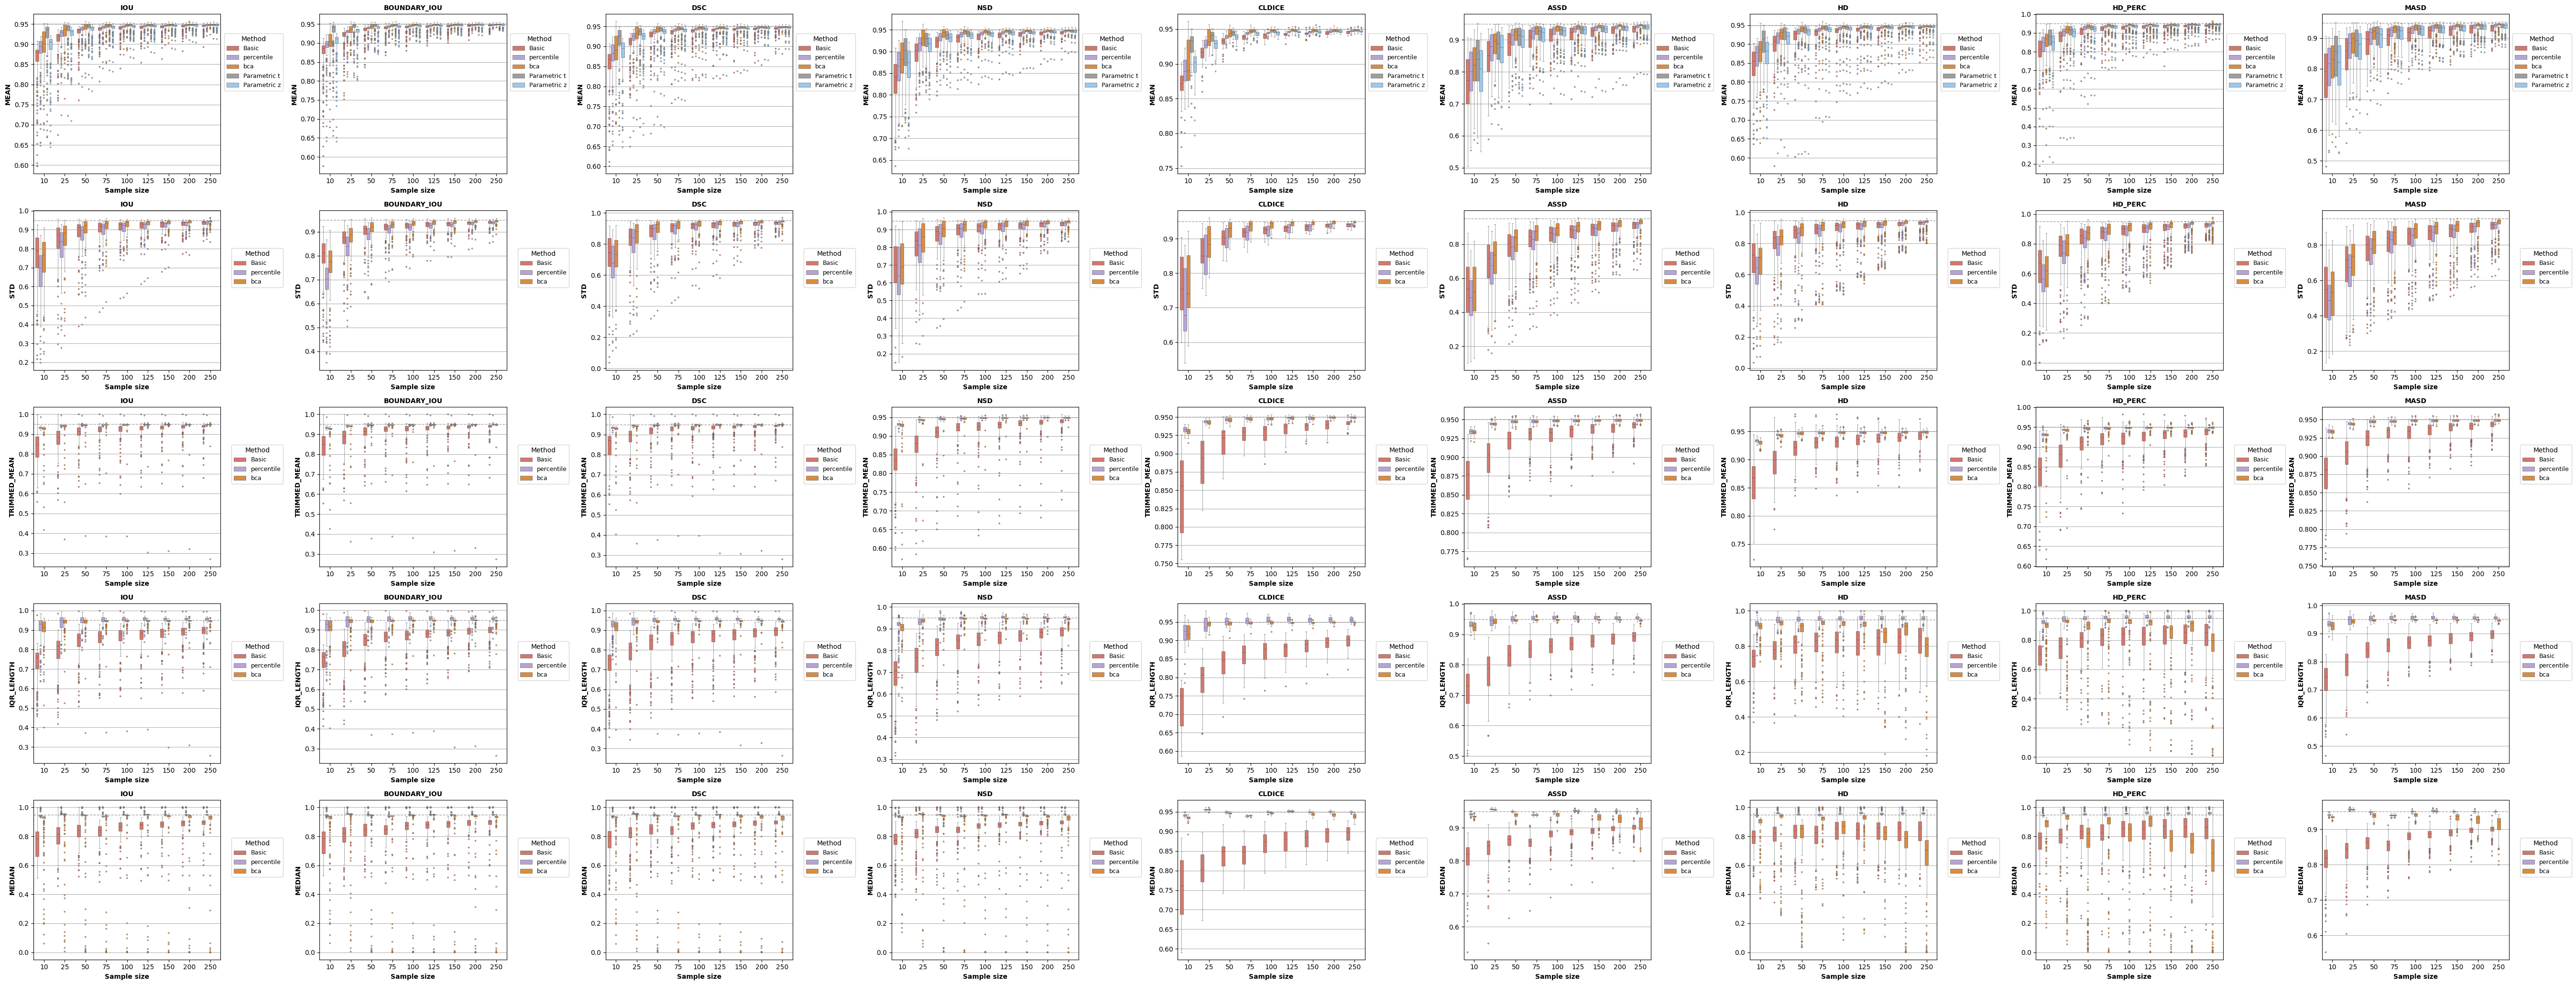

In [7]:

method_colors = {
    'Basic': '#e26b5b',
    'percentile': '#b39ddb',
    'bca': '#f28c28',
    'Parametric t': '#9e9e9e',
    'Parametric z': '#90caf9'
}
hue_order = ['Basic', 'percentile', 'bca', 'Parametric t', 'Parametric z']

# Unique stats and metrics

n_rows = len(stats)
n_cols = len(metrics)
all_metrics = df['metric'].unique()
bounded_metrics=['iou', 'boundary_iou', 'dsc','nsd','cldice']
unbounded_metrics = [m for m in all_metrics if m not in bounded_metrics]
metric_order = bounded_metrics + sorted(unbounded_metrics)

# Define stat order
fixed_stats = ['mean', 'std', 'trimmed_mean']
all_stats = df['stat'].unique()
remaining_stats = [s for s in all_stats if s not in fixed_stats]
stat_order = fixed_stats + sorted(remaining_stats)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows), squeeze=False)

for i, stat in enumerate(stat_order):
    for j, metric in enumerate(metric_order):
        ax = axes[i][j]
        ax.axhline(0.95, linestyle='--', color='gray', linewidth=1, alpha=0.7)
        # Filter data for this stat and metric
        df_sub = df[(df['stat'] == stat) & (df['metric'] == metric)]
        df_sub=df_sub.sort_values(by='n')
        # Plot boxplot
        
        sns.boxplot(
            data=df_sub,
            x='x_group',
            y='coverage',
            hue='method',
            hue_order=hue_order,
            palette=method_colors,
            showfliers=False,
            width=0.8,
            ax=ax, 
            linewidth=0.4
        )

        # Compute whiskers and outliers
        whiskers = {}
        groups = df_sub.groupby(['x_group', 'method'])
        lower_whiskers = []
        for (x_group, method), group_data in groups:
            Q1 = group_data['coverage'].quantile(0.25)
            Q3 = group_data['coverage'].quantile(0.75)
            IQR = Q3 - Q1
            lw = Q1 - 1.5 * IQR
            uw = Q3 + 1.5 * IQR
            whiskers[(x_group, method)] = (lw, uw)
            lower_whiskers.append(lw)

        y_lower_limit = min(lower_whiskers) if lower_whiskers else 0

        outliers = []
        for (x_group, method), (lw, uw) in whiskers.items():
            subset = df_sub[(df_sub['x_group'] == x_group) & (df_sub['method'] == method)]
            outliers.append(subset[(subset['coverage'] < lw) | (subset['coverage'] > uw)])

        outliers_df = pd.concat(outliers) if outliers else pd.DataFrame(columns=df_sub.columns)

        if not outliers_df.empty:
            sns.stripplot(
                data=outliers_df,
                x='x_group',
                y='coverage',
                hue='method',
                hue_order=hue_order,
                palette=method_colors,
                dodge=True,
                jitter=0.0,
                alpha=0.8,
                size=2,
                legend=False,
                edgecolor="auto",
                linewidth=0.5,
                ax=ax
            )

        # Clean x-axis labels
        xtick_labels = [label.get_text().replace('n=', '').replace('.0', '').split('\n')[-1] for label in ax.get_xticklabels()]
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(xtick_labels, rotation=0)

        # Axis titles and labels
    
        ax.set_title(metric.upper(), fontsize=10, weight='bold')
    
        ax.set_ylabel(f"{stat.upper()}",fontsize=10,weight='bold')
    
        ax.set_xlabel('Sample size', weight='bold',fontsize=10)
        # ax.set_ylim(0.5- 0.01, 1.01)
        ax.grid(axis='y')
        # ax.set_ylim(y_lower_limit - 0.01, 1.01)
        dodge_width = 0.5  # total spread
        methods = hue_order
        method_offsets = {
            method: -dodge_width / 2 + i * (dodge_width / (len(methods)-1 if len(methods) > 1 else 1))
            for i, method in enumerate(methods)
        }
# --- Annotate clipped outliers ---
        for (x_group, method), (lw, uw) in whiskers.items():
            
            subset = df_sub[(df_sub['x_group'] == x_group) & (df_sub['method'] == method)]
            coverages = subset['coverage']
           

            # Skip if IQR is not fully within the plot (box is truncated)
            if lw < 0.5- 0.01:
                continue 
            count_below = (coverages < ax.get_ylim()[0]).sum()
            count_above = (coverages > ax.get_ylim()[1]).sum()
            x_pos = list(df_sub['x_group'].unique()).index(x_group)
            offset = method_offsets[method]
            pos = x_pos + offset
            if count_below > 0:
                ax.annotate(f'{count_below}',
                            xy=(pos, ax.get_ylim()[0] + 0.005),
                            xytext=(pos, ax.get_ylim()[0] + 0.035),
                            ha='center',
                            arrowprops=dict(
                                facecolor=method_colors[method],
                                shrink=0.05,
                                width=6,
                                headwidth=10, alpha=0.8, linewidth=0.4
                            ),
                            bbox=dict(boxstyle='square,pad=0.1', fc="white", ec="none", alpha=0),
                            fontsize=8,
                            color=method_colors[method])
                # ax.annotate(f'{count_below}',
                #                                 xy=(pos, 0.505),
                #                                 xytext=(pos, 0.525),
                #                                 ha='center',
                #                                 arrowprops=dict(facecolor=colors[method], shrink=0.05, width=8, headwidth=16),
                #                                 bbox = dict(boxstyle='square,pad=0.1', fc="white", ec="none"),
                #                                 fontsize=60, color=colors[method])
            if count_above > 0:
                ax.annotate(f'{count_above}',
                            xy=(pos, ax.get_ylim()[1] - 0.005),
                            xytext=(pos, ax.get_ylim()[1] - 0.005),
                            ha='center',
                            va='bottom',
                            fontsize=10,
                            fontweight="bold",
                            bbox=dict(
                                boxstyle='circle,pad=0.1',
                                fc="none",
                                ec=method_colors[method],
                                lw=2
                            ),
                            color=method_colors[method])
                # Remove duplicate legends
        handles, labels = ax.get_legend_handles_labels()

            # Determine which methods are present in the subplot's data
        methods_in_data = df_sub['method'].unique()

        # Filter the legend entries
        filtered_handles_labels = [
            (h, l) for h, l in zip(handles, labels) if l in methods_in_data
        ]
       
        # Apply filtered legend
        if filtered_handles_labels:
            handles_filt, labels_filt = zip(*filtered_handles_labels)
            ax.legend(handles_filt, labels_filt, title="Method", loc="lower right",  bbox_to_anchor=(1.35, 0.5), fontsize=9, title_fontsize=10)
        else:
            ax.legend_.remove()



# Adjust layout
plt.subplots_adjust(bottom=0.15, wspace=0.2, hspace=0.4)
plt.title('')
plt.tight_layout(rect=[0, 0.08, 1, 1])  # Leave space for legend
fig.savefig("segmentation_all.pdf", format="pdf", bbox_inches="tight")
plt.show()


### Width

In [8]:
metrics=['iou', 'boundary_iou','assd', 'cldice', 'hd', 'dsc', 'nsd', 'masd', 'hd_perc' ]
stats=['mean', 'median', 'std', 'trimmed_mean', 'iqr_length']
all_values=[]
for metric in metrics:
    for stat in stats:
        file_path = f"../../données/segmentation/results_metrics/aggregated_results_{metric}_{stat}.csv"
        data = pd.read_csv(file_path)
        n_subset=data['n'].unique()
        tasks=data['subtask'].unique()
        algos=data['alg_name'].unique()
        for task in tasks: 
            data_task=data[data['subtask']==task]
            for algo in algos: 
                data_algo=data_task[data_task['alg_name']==algo]
        for n in n_subset:  # Show only selected n values
            data_n = data[data['n'] == n]
            method_dict = {
                'Basic': 'width_basic',
                'bca': 'width_bca',
                'percentile': 'width_percentile',
            }

            # Add parametric methods only for stat == 'mean'
            if stat == 'mean':
                method_dict.update({
                    'Parametric z': 'width_param_z',
                    'Parametric t': 'width_param_t'
                })
            for method, col in method_dict.items():
                for val in data_n[col]:
                    all_values.append({
                        'metric': metric,
                        'stat': stat,
                        'n': n,
                        'method': method,
                        'width': val,
                        'x_group': f"{metric}\nn={n}"
                    })

In [9]:
df_width=pd.DataFrame(all_values)

In [10]:
df_width

,metric,stat,n,method,width,x_group
0,iou,mean,10.0,Basic,0.255972,iou\nn=10.0
1,iou,mean,10.0,Basic,0.255771,iou\nn=10.0
2,iou,mean,10.0,Basic,0.251752,iou\nn=10.0
3,iou,mean,10.0,Basic,0.200827,iou\nn=10.0
4,iou,mean,10.0,Basic,0.261814,iou\nn=10.0
...,...,...,...,...,...,...
276619,hd_perc,iqr_length,250.0,percentile,37.411731,hd_perc\nn=250.0
276620,hd_perc,iqr_length,250.0,percentile,35.539874,hd_perc\nn=250.0
276621,hd_perc,iqr_length,250.0,percentile,27.964904,hd_perc\nn=250.0
276622,hd_perc,iqr_length,250.0,percentile,24.989671,hd_perc\nn=250.0


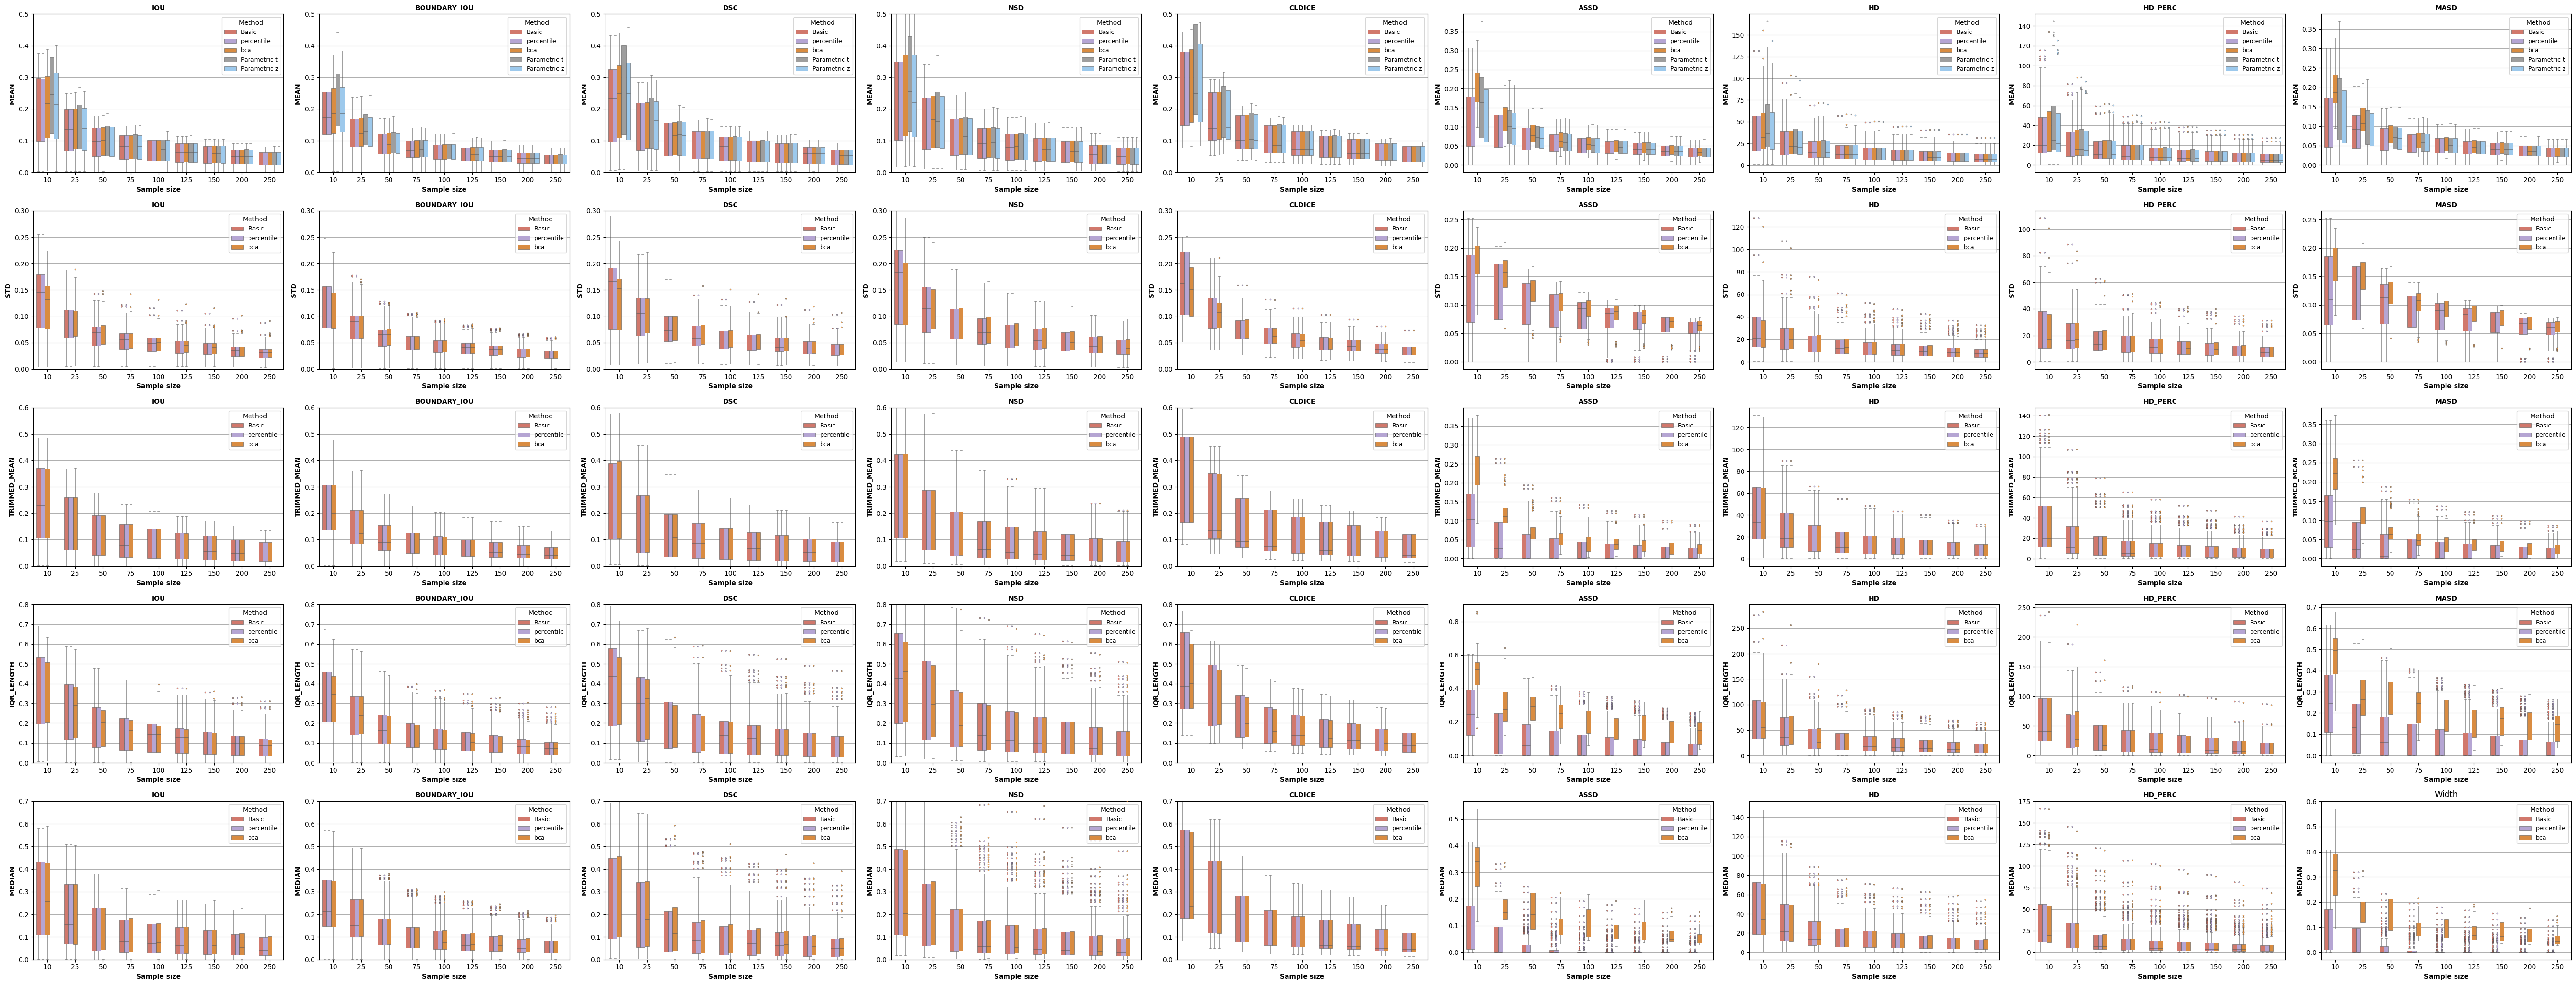

In [11]:

method_colors = {
    'Basic': '#e26b5b',
    'percentile': '#b39ddb',
    'bca': '#f28c28',
    'Parametric t': '#9e9e9e',
    'Parametric z': '#90caf9'
}
hue_order = ['Basic', 'percentile', 'bca', 'Parametric t', 'Parametric z']

# Unique stats and metrics

n_rows = len(stats)
n_cols = len(metrics)
all_metrics = df_width['metric'].unique()
bounded_metrics=['iou', 'boundary_iou', 'dsc','nsd','cldice']
unbounded_metrics = [m for m in all_metrics if m not in bounded_metrics]
metric_order = bounded_metrics + sorted(unbounded_metrics)

# Define stat order
fixed_stats = ['mean', 'std', 'trimmed_mean']
all_stats = df_width['stat'].unique()
remaining_stats = [s for s in all_stats if s not in fixed_stats]
stat_order = fixed_stats + sorted(remaining_stats)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows), squeeze=False)

for i, stat in enumerate(stat_order):
    for j, metric in enumerate(metric_order):
        ax = axes[i][j]

        # Filter data for this stat and metric
        df_sub = df_width[(df_width['stat'] == stat) & (df_width['metric'] == metric)]
        df_sub=df_sub.sort_values(by='n')
        # Plot boxplot
        
        sns.boxplot(
            data=df_sub,
            x='x_group',
            y='width',
            hue='method',
            hue_order=hue_order,
            palette=method_colors,
            showfliers=False,
            width=0.8,
            ax=ax, 
            linewidth=0.4
        )

        # Compute whiskers and outliers
        whiskers = {}
        groups = df_sub.groupby(['x_group', 'method'])
        lower_whiskers = []
        for (x_group, method), group_data in groups:
            Q1 = group_data['width'].quantile(0.25)
            Q3 = group_data['width'].quantile(0.75)
            IQR = Q3 - Q1
            lw = Q1 - 1.5 * IQR
            uw = Q3 + 1.5 * IQR
            whiskers[(x_group, method)] = (lw, uw)
            lower_whiskers.append(lw)

        y_lower_limit = min(lower_whiskers) if lower_whiskers else 0

        outliers = []
        for (x_group, method), (lw, uw) in whiskers.items():
            subset = df_sub[(df_sub['x_group'] == x_group) & (df_sub['method'] == method)]
            outliers.append(subset[(subset['width'] < lw) | (subset['width'] > uw)])

        outliers_df = pd.concat(outliers) if outliers else pd.DataFrame(columns=df_sub.columns)

        if not outliers_df.empty:
            sns.stripplot(
                data=outliers_df,
                x='x_group',
                y='width',
                hue='method',
                hue_order=hue_order,
                palette=method_colors,
                dodge=True,
                jitter=0.0,
                alpha=0.8,
                size=2,
                legend=False,
                edgecolor="auto",
                linewidth=0.5,
                ax=ax
            )

        # Clean x-axis labels
        xtick_labels = [label.get_text().replace('n=', '').replace('.0', '').split('\n')[-1] for label in ax.get_xticklabels()]
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(xtick_labels, rotation=0)

        # Axis titles and labels
      
        ax.set_title(metric.upper(), fontsize=10, weight='bold')
    
        ax.set_ylabel(f"{stat.upper()}",fontsize=10,weight='bold')
    
        ax.set_xlabel('Sample size', weight='bold',fontsize=10)
        if metric in bounded_metrics:
            if stat=='mean':
                ax.set_ylim(0,0.5)
            elif stat=='std':
                ax.set_ylim(0,0.3)
            elif stat=='trimmed_mean':
                ax.set_ylim(0,0.6)
            elif stat=='iqr_length':
                ax.set_ylim(0,0.8)
            else:
                ax.set_ylim(0,0.7)
        ax.grid(axis='y')
        # ax.set_ylim(y_lower_limit - 0.01, 1.01)
        dodge_width = 0.5  # total spread
        methods = hue_order
        method_offsets = {
            method: -dodge_width / 2 + i * (dodge_width / (len(methods)-1 if len(methods) > 1 else 1))
            for i, method in enumerate(methods)
        }
        used_methods = set()
# --- Annotate clipped outliers ---
        for (x_group, method), (lw, uw) in whiskers.items():
            used_methods.add(method)
            subset = df_sub[(df_sub['x_group'] == x_group) & (df_sub['method'] == method)]
            coverages = subset['width']
           

            # Skip if IQR is not fully within the plot (box is truncated)
            if lw < 0.5- 0.01:
                continue 
            count_below = (coverages < ax.get_ylim()[0]).sum()
            count_above = (coverages > ax.get_ylim()[1]).sum()
            x_pos = list(df_sub['x_group'].unique()).index(x_group)
            offset = method_offsets[method]
            pos = x_pos + offset
            if count_below > 0:
                ax.annotate(f'{count_below}',
                            xy=(pos, ax.get_ylim()[0] + 0.005),
                            xytext=(pos, ax.get_ylim()[0] + 0.035),
                            ha='center',
                            arrowprops=dict(
                                facecolor=method_colors[method],
                                shrink=0.05,
                                width=6,
                                headwidth=10, alpha=0.8, linewidth=0.4
                            ),
                            bbox=dict(boxstyle='square,pad=0.1', fc="white", ec="none", alpha=0),
                            fontsize=8,
                            color=method_colors[method])
                # ax.annotate(f'{count_below}',
                #                                 xy=(pos, 0.505),
                #                                 xytext=(pos, 0.525),
                #                                 ha='center',
                #                                 arrowprops=dict(facecolor=colors[method], shrink=0.05, width=8, headwidth=16),
                #                                 bbox = dict(boxstyle='square,pad=0.1', fc="white", ec="none"),
                #                                 fontsize=60, color=colors[method])
            if count_above > 0:
                ax.annotate(f'{count_above}',
                            xy=(pos, ax.get_ylim()[1] - 0.005),
                            xytext=(pos, ax.get_ylim()[1] - 0.005),
                            ha='center',
                            va='bottom',
                            fontsize=10,
                            fontweight="bold",
                            bbox=dict(
                                boxstyle='circle,pad=0.1',
                                fc="none",
                                ec=method_colors[method],
                                lw=2
                            ),
                            color=method_colors[method])
                # Remove duplicate legends
      
        handles, labels = ax.get_legend_handles_labels()

            # Determine which methods are present in the subplot's data
        methods_in_data = df_sub['method'].unique()

        # Filter the legend entries
        filtered_handles_labels = [
            (h, l) for h, l in zip(handles, labels) if l in methods_in_data
        ]
        
        # Apply filtered legend
        if filtered_handles_labels:
            handles_filt, labels_filt = zip(*filtered_handles_labels)
            ax.legend(handles_filt, labels_filt, title="Method", loc="upper right", fontsize=9, title_fontsize=10)
        else:
            ax.legend_.remove()


# Adjust layout
plt.subplots_adjust(bottom=0.15, wspace=0.2, hspace=0.4)
plt.title('Width')
plt.tight_layout(rect=[0, 0.08, 1, 1])  # Leave space for legend
fig.savefig("segmentation_all_width.pdf", format="pdf", bbox_inches="tight")
plt.show()


## Classification

### Micro

In [12]:

stats=['accuracy', 'ap', 'auc', 'balanced_accuracy', 'f1_score', 'mcc']
all_values=[]

for stat in stats:
    file_path = f"../../données/classif/results_metrics_classif/aggregated_results_{stat}.csv"
    data = pd.read_csv(file_path)
    
    n_subset=data['n'].unique()
    tasks=data['subtask'].unique()
    algos=data['alg_name'].unique()
    for task in tasks: 
        data_task=data[data['subtask']==task]
        for algo in algos: 
            data_algo=data_task[data_task['alg_name']==algo]
            for n in n_subset:  # Show only selected n values
                data_n = data_algo[data_algo['n'] == n]
                
                method_dict = {
                    'Basic': 'coverage_basic',
                    'bca': 'coverage_bca',
                    'percentile': 'coverage_percentile',
                }

                # Add parametric methods only for stat == 'mean'
                if stat == 'accuracy':
                    method_dict.update({
                        'agresti_coull':'coverage_agresti_coull',
                        'wilson':'coverage_wilson',
                        'exact':'coverage_exact',
                        'wald': 'coverage_wald'
                    })
                elif stat=='auc':
                    method_dict.update({
                        'delong':'coverage_delong',
                        'logit_transform':'coverage_logit_transform',
                    })
        
                for method, col in method_dict.items():
                    for val in data_n[col]:
                        all_values.append({
                            'subtask':task, 
                            'algo':algo,
                            'stat': stat,
                            'n': n,
                            'method': method,
                            'value': val,
                        
                            'x_group': f"n={n}"
                        })

In [13]:
df_coverage=pd.DataFrame(all_values)
df_coverage_micro=df_coverage[df_coverage['stat']!='balanced_accuracy']

In [14]:
df_coverage_micro

,subtask,algo,stat,n,method,value,x_group
0,aptos19_blindness_detection,alg_1,accuracy,10.0,Basic,0.8517,n=10.0
1,aptos19_blindness_detection,alg_1,accuracy,10.0,bca,0.8705,n=10.0
2,aptos19_blindness_detection,alg_1,accuracy,10.0,percentile,0.8517,n=10.0
3,aptos19_blindness_detection,alg_1,accuracy,10.0,agresti_coull,0.9781,n=10.0
4,aptos19_blindness_detection,alg_1,accuracy,10.0,wilson,0.9781,n=10.0
...,...,...,...,...,...,...,...
45139,mura_xr_forearm,alg_9,mcc,200.0,bca,0.9089,n=200.0
45140,mura_xr_forearm,alg_9,mcc,200.0,percentile,0.8879,n=200.0
45141,mura_xr_forearm,alg_9,mcc,250.0,Basic,0.8497,n=250.0
45142,mura_xr_forearm,alg_9,mcc,250.0,bca,0.8987,n=250.0


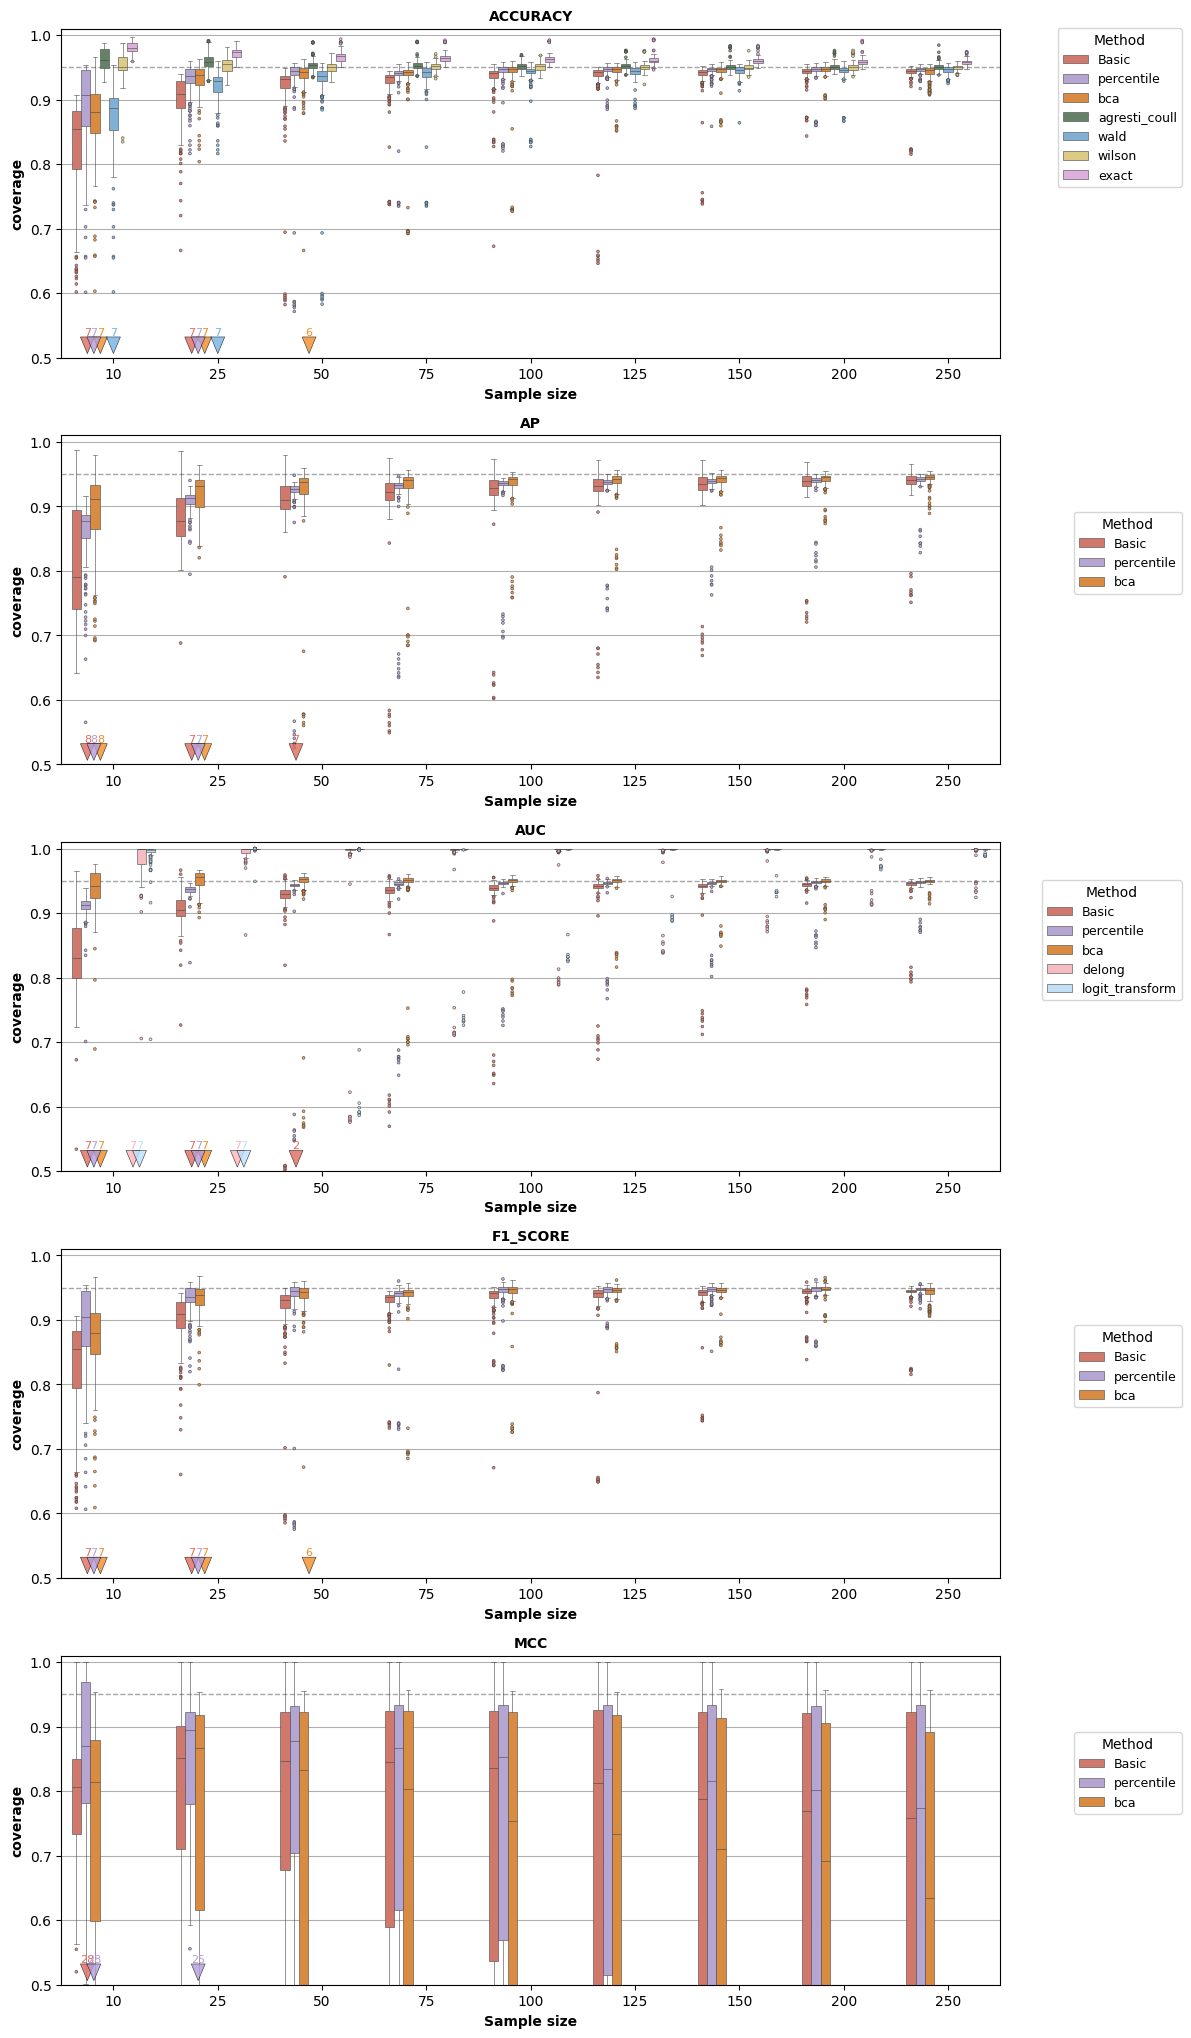

In [15]:


method_colors = {
    'Basic': '#e26b5b',
    'percentile': '#b39ddb',
    'bca': '#f28c28',
    'agresti_coull': "#5f8761",
    'wald': "#74b2e3",
    'wilson': "#ecd476", 
    'exact': "#e3a7e5",
    'delong':'#ffb3ba',
    'logit_transform':'#bae1ff',
}
hue_order = ['Basic', 'percentile', 'bca', 'agresti_coull', 'wald', 'wilson','exact', 'delong', 'logit_transform']
        




# Define stat order

all_stats = df_coverage_micro['stat'].unique()


n_rows = len(all_stats)
n_cols = 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12 * n_cols, 4.5 * n_rows), squeeze=False)

for i, stat in enumerate(all_stats):
    ax = axes[i][0]
    ax.axhline(0.95, linestyle='--', color='gray', linewidth=1, alpha=0.7)
    # Filter data for this stat and metric
    df_sub = df_coverage_micro[(df_coverage_micro['stat'] == stat)]
    df_sub=df_sub.sort_values(by='n')
    # Plot boxplot
    
    sns.boxplot(
        data=df_sub,
        x='x_group',
        y='value',
        hue='method',
        hue_order=hue_order,
        palette=method_colors,
        showfliers=False,
        width=0.8,
        ax=ax, 
        linewidth=0.4
    )

    # Compute whiskers and outliers
    whiskers = {}
    groups = df_sub.groupby(['x_group', 'method'])
    lower_whiskers = []
    for (x_group, method), group_data in groups:
        Q1 = group_data['value'].quantile(0.25)
        Q3 = group_data['value'].quantile(0.75)
        IQR = Q3 - Q1
        lw = Q1 - 1.5 * IQR
        uw = Q3 + 1.5 * IQR
        whiskers[(x_group, method)] = (lw, uw)
        lower_whiskers.append(lw)

    y_lower_limit = min(lower_whiskers) if lower_whiskers else 0

    outliers = []
    for (x_group, method), (lw, uw) in whiskers.items():
        subset = df_sub[(df_sub['x_group'] == x_group) & (df_sub['method'] == method)]
        outliers.append(subset[(subset['value'] < lw) | (subset['value'] > uw)])

    outliers_df = pd.concat(outliers) if outliers else pd.DataFrame(columns=df_sub.columns)
    
    if not outliers_df.empty:
        sns.stripplot(
            data=outliers_df,
            x='x_group',
            y='value',
            hue='method',
            hue_order=hue_order,
            palette=method_colors,
            dodge=True,
            jitter=0.0,
            alpha=0.8,
            size=2,
            legend=False,
            edgecolor="auto",
            linewidth=0.5,
            ax=ax
        )

    # Clean x-axis labels
    xtick_labels = [label.get_text().replace('n=', '').replace('.0', '').split('\n')[-1] for label in ax.get_xticklabels()]
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(xtick_labels, rotation=0)
    ax.set_ylim(0.5, 1.01)
    # Axis titles and labels
    
    ax.set_title(stat.upper(), fontsize=10, weight='bold')

    ax.set_ylabel(f"coverage",fontsize=10,weight='bold')

    ax.set_xlabel('Sample size', weight='bold',fontsize=10)
    # ax.set_ylim(0.5- 0.01, 1.01)
    ax.grid(axis='y')
    # ax.set_ylim(y_lower_limit - 0.01, 1.01)
    dodge_width = 0.5  # total spread
    methods = hue_order
    method_offsets = {
        method: -dodge_width / 2 + i * (dodge_width / (len(methods)-1 if len(methods) > 1 else 1))
        for i, method in enumerate(methods)
    }
# --- Annotate clipped outliers ---
    for (x_group, method), (lw, uw) in whiskers.items():
        
        subset = df_sub[(df_sub['x_group'] == x_group) & (df_sub['method'] == method)]
        coverages = subset['value']
        

        # Skip if IQR is not fully within the plot (box is truncated)
        if lw < 0.5- 0.01:
            continue 
        count_below = (coverages < ax.get_ylim()[0]).sum()
        count_above = (coverages > ax.get_ylim()[1]).sum()
        x_pos = list(df_sub['x_group'].unique()).index(x_group)
        offset = method_offsets[method]
        pos = x_pos + offset
        if count_below > 0:
            ax.annotate(f'{count_below}',
                        xy=(pos, ax.get_ylim()[0] + 0.005),
                        xytext=(pos, ax.get_ylim()[0] + 0.035),
                        ha='center',
                        arrowprops=dict(
                            facecolor=method_colors[method],
                            shrink=0.05,
                            width=6,
                            headwidth=10, alpha=0.8, linewidth=0.4
                        ),
                        bbox=dict(boxstyle='square,pad=0.1', fc="white", ec="none", alpha=0),
                        fontsize=8,
                        color=method_colors[method])
            # ax.annotate(f'{count_below}',
            #                                 xy=(pos, 0.505),
            #                                 xytext=(pos, 0.525),
            #                                 ha='center',
            #                                 arrowprops=dict(facecolor=colors[method], shrink=0.05, width=8, headwidth=16),
            #                                 bbox = dict(boxstyle='square,pad=0.1', fc="white", ec="none"),
            #                                 fontsize=60, color=colors[method])
        if count_above > 0:
            ax.annotate(f'{count_above}',
                        xy=(pos, ax.get_ylim()[1] - 0.005),
                        xytext=(pos, ax.get_ylim()[1] - 0.005),
                        ha='center',
                        va='bottom',
                        fontsize=10,
                        fontweight="bold",
                        bbox=dict(
                            boxstyle='circle,pad=0.1',
                            fc="none",
                            ec=method_colors[method],
                            lw=2
                        ),
                        color=method_colors[method])
            # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()

        # Determine which methods are present in the subplot's data
    methods_in_data = df_sub['method'].unique()

    # Filter the legend entries
    filtered_handles_labels = [
        (h, l) for h, l in zip(handles, labels) if l in methods_in_data
    ]
    
    # Apply filtered legend
    if filtered_handles_labels:
        handles_filt, labels_filt = zip(*filtered_handles_labels)
        ax.legend(handles_filt, labels_filt, title="Method", loc="lower right",  bbox_to_anchor=(1.2, 0.5), fontsize=9, title_fontsize=10)
    else:
        ax.legend_.remove()


plt.subplots_adjust(bottom=0.15, wspace=0.2, hspace=0.4)

plt.tight_layout(rect=[0, 0.08, 1, 1])  # Leave space for legend
fig.savefig("classification_all.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [16]:

stats=['accuracy', 'ap', 'auc', 'balanced_accuracy', 'f1_score', 'mcc']
all_values=[]

for stat in stats:
    file_path = f"../../données/classif/results_metrics_classif/aggregated_results_{stat}.csv"
    data = pd.read_csv(file_path)
    
    n_subset=data['n'].unique()
    tasks=data['subtask'].unique()
    algos=data['alg_name'].unique()
    for task in tasks: 
        data_task=data[data['subtask']==task]
        for algo in algos: 
            data_algo=data_task[data_task['alg_name']==algo]
            for n in n_subset:  # Show only selected n values
                data_n = data[data['n'] == n]
                
                method_dict = {
                    'Basic': 'width_basic',
                    'bca': 'width_bca',
                    'percentile': 'width_percentile',
                }

                # Add parametric methods only for stat == 'mean'
                if stat == 'accuracy':
                    method_dict.update({
                        'agresti_coull':'width_agresti_coull',
                        'wilson':'width_wilson',
                        'exact':'width_exact',
                        'wald': 'width_wald'
                    })
                elif stat=='auc':
                    method_dict.update({
                        'delong':'width_delong',
                        'logit_transform':'width_logit_transform',
                    })
              
                for method, col in method_dict.items():
                    for val in data_n[col]:
                        all_values.append({
                            'stat': stat,
                            'n': n,
                            'method': method,
                            'width': val,
                            'x_group': f"n={n}"
                        })

In [17]:
df_width=pd.DataFrame(all_values)
df_width_micro=df_width[df_width['stat']!='balanced_accuracy']

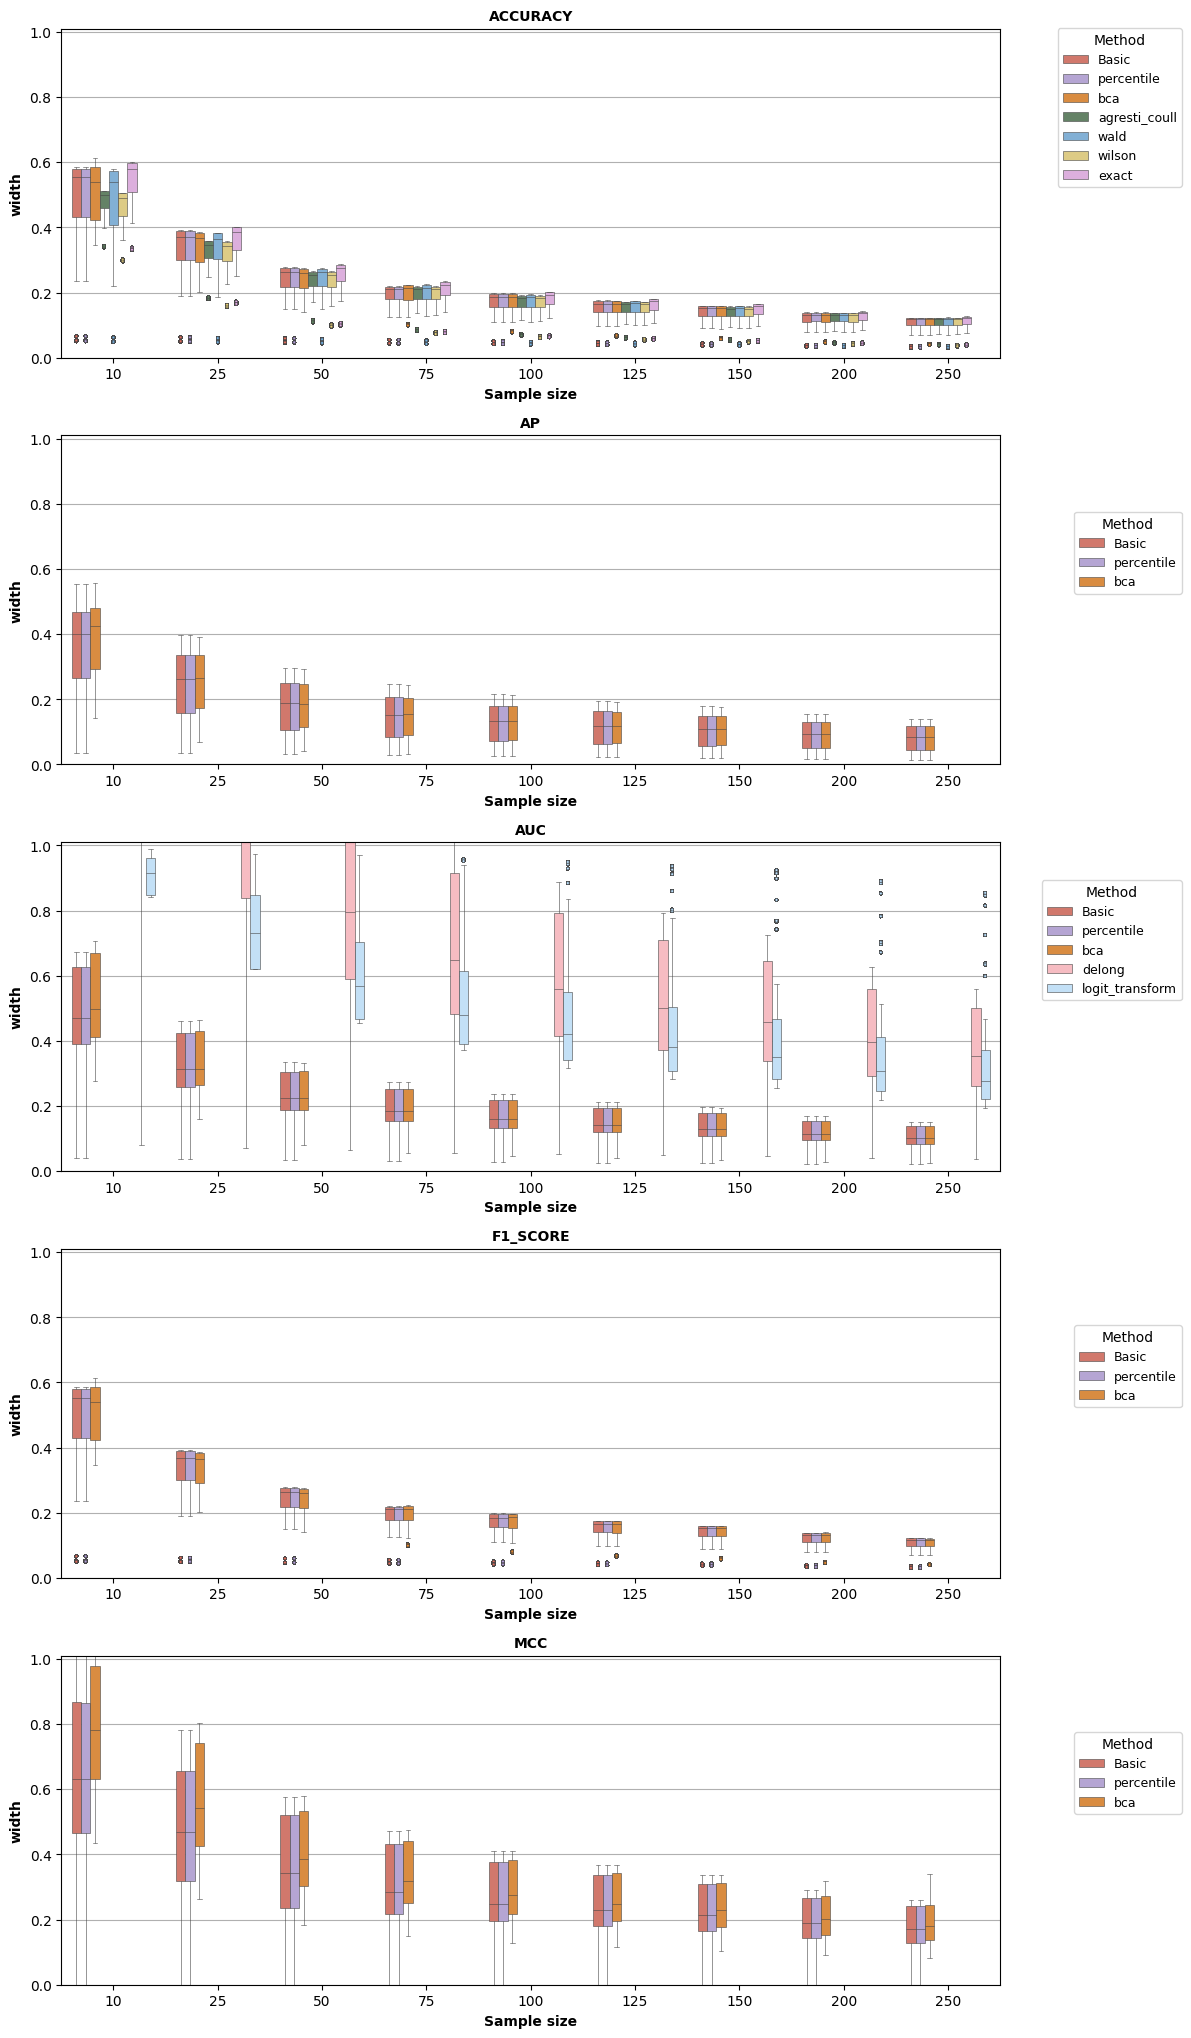

In [18]:

method_colors = {
    'Basic': '#e26b5b',
    'percentile': '#b39ddb',
    'bca': '#f28c28',
    'agresti_coull': "#5f8761",
    'wald': "#74b2e3",
    'wilson': "#ecd476", 
    'exact': "#e3a7e5",
    'delong':'#ffb3ba',
    'logit_transform':'#bae1ff',
}
hue_order = ['Basic', 'percentile', 'bca', 'agresti_coull', 'wald', 'wilson','exact', 'delong', 'logit_transform']
        




# Define stat order

all_stats = df_width_micro['stat'].unique()

n_rows = len(all_stats)
n_cols = 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12* n_cols, 4.5 * n_rows), squeeze=False)

for i, stat in enumerate(all_stats):
    ax = axes[i][0]
    
    # Filter data for this stat and metric
    df_sub = df_width_micro[(df_width_micro['stat'] == stat)]
    df_sub=df_sub.sort_values(by='n')
    # Plot boxplot
    
    sns.boxplot(
        data=df_sub,
        x='x_group',
        y='width',
        hue='method',
        hue_order=hue_order,
        palette=method_colors,
        showfliers=False,
        width=0.8,
        ax=ax, 
        linewidth=0.4
    )

    # Compute whiskers and outliers
    whiskers = {}
    groups = df_sub.groupby(['x_group', 'method'])
    lower_whiskers = []
    for (x_group, method), group_data in groups:
        Q1 = group_data['width'].quantile(0.25)
        Q3 = group_data['width'].quantile(0.75)
        IQR = Q3 - Q1
        lw = Q1 - 1.5 * IQR
        uw = Q3 + 1.5 * IQR
        whiskers[(x_group, method)] = (lw, uw)
        lower_whiskers.append(lw)

    y_lower_limit = min(lower_whiskers) if lower_whiskers else 0

    outliers = []
    for (x_group, method), (lw, uw) in whiskers.items():
        subset = df_sub[(df_sub['x_group'] == x_group) & (df_sub['method'] == method)]
        outliers.append(subset[(subset['width'] < lw) | (subset['width'] > uw)])

    outliers_df = pd.concat(outliers) if outliers else pd.DataFrame(columns=df_sub.columns)

    if not outliers_df.empty:
        sns.stripplot(
            data=outliers_df,
            x='x_group',
            y='width',
            hue='method',
            hue_order=hue_order,
            palette=method_colors,
            dodge=True,
            jitter=0.0,
            alpha=0.8,
            size=2,
            legend=False,
            edgecolor="auto",
            linewidth=0.5,
            ax=ax
        )

    # Clean x-axis labels
    xtick_labels = [label.get_text().replace('n=', '').replace('.0', '').split('\n')[-1] for label in ax.get_xticklabels()]
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(xtick_labels, rotation=0)

    # Axis titles and labels
    
    ax.set_title(stat.upper(), fontsize=10, weight='bold')

    ax.set_ylabel(f"width",fontsize=10,weight='bold')
    ax.set_ylim(0,1.01)
    ax.set_xlabel('Sample size', weight='bold',fontsize=10)
    # ax.set_ylim(0.5- 0.01, 1.01)
    ax.grid(axis='y')
    # ax.set_ylim(y_lower_limit - 0.01, 1.01)
    dodge_width = 0.5  # total spread
    methods = hue_order
    method_offsets = {
        method: -dodge_width / 2 + i * (dodge_width / (len(methods)-1 if len(methods) > 1 else 1))
        for i, method in enumerate(methods)
    }
# --- Annotate clipped outliers ---
    for (x_group, method), (lw, uw) in whiskers.items():
        
        subset = df_sub[(df_sub['x_group'] == x_group) & (df_sub['method'] == method)]
        coverages = subset['width']
        

        # Skip if IQR is not fully within the plot (box is truncated)
        if lw < 0.5- 0.01:
            continue 
        count_below = (coverages < ax.get_ylim()[0]).sum()
        count_above = (coverages > ax.get_ylim()[1]).sum()
        x_pos = list(df_sub['x_group'].unique()).index(x_group)
        offset = method_offsets[method]
        pos = x_pos + offset
        if count_below > 0:
            ax.annotate(f'{count_below}',
                        xy=(pos, ax.get_ylim()[0] + 0.005),
                        xytext=(pos, ax.get_ylim()[0] + 0.035),
                        ha='center',
                        arrowprops=dict(
                            facecolor=method_colors[method],
                            shrink=0.05,
                            width=6,
                            headwidth=10, alpha=0.8, linewidth=0.4
                        ),
                        bbox=dict(boxstyle='square,pad=0.1', fc="white", ec="none", alpha=0),
                        fontsize=8,
                        color=method_colors[method])
            # ax.annotate(f'{count_below}',
            #                                 xy=(pos, 0.505),
            #                                 xytext=(pos, 0.525),
            #                                 ha='center',
            #                                 arrowprops=dict(facecolor=colors[method], shrink=0.05, width=8, headwidth=16),
            #                                 bbox = dict(boxstyle='square,pad=0.1', fc="white", ec="none"),
            #                                 fontsize=60, color=colors[method])
        if count_above > 0:
            ax.annotate(f'{count_above}',
                        xy=(pos, ax.get_ylim()[1] - 0.005),
                        xytext=(pos, ax.get_ylim()[1] - 0.005),
                        ha='center',
                        va='bottom',
                        fontsize=10,
                        fontweight="bold",
                        bbox=dict(
                            boxstyle='circle,pad=0.1',
                            fc="none",
                            ec=method_colors[method],
                            lw=2
                        ),
                        color=method_colors[method])
            # Remove duplicate legends
    handles, labels = ax.get_legend_handles_labels()

        # Determine which methods are present in the subplot's data
    methods_in_data = df_sub['method'].unique()

    # Filter the legend entries
    filtered_handles_labels = [
        (h, l) for h, l in zip(handles, labels) if l in methods_in_data
    ]
    
    # Apply filtered legend
    if filtered_handles_labels:
        handles_filt, labels_filt = zip(*filtered_handles_labels)
        ax.legend(handles_filt, labels_filt, title="Method", loc="lower right",  bbox_to_anchor=(1.2, 0.5), fontsize=9, title_fontsize=10)
    else:
        ax.legend_.remove()

# Global legend
# fig.legend(handles, labels, title='Method', loc='lower center', ncol=len(hue_order), frameon=False,fontsize=20,          # Increase legend label font size
#     title_fontsize=25)

# Adjust layout
plt.subplots_adjust(bottom=0.15, wspace=0.2, hspace=0.4)

plt.tight_layout(rect=[0, 0.08, 1, 1])  # Leave space for legend
fig.savefig("classification_width_micro.pdf", format="pdf", bbox_inches="tight")
plt.show()


## Balanced accuracy

In [19]:

df_ba=df_coverage[df_coverage['stat']=='balanced_accuracy']

In [20]:
df_ba

,subtask,algo,stat,n,method,value,x_group
28215,aptos19_blindness_detection,alg_1,balanced_accuracy,10.0,Basic,0.4801,n=10.0
28216,aptos19_blindness_detection,alg_1,balanced_accuracy,10.0,bca,0.4096,n=10.0
28217,aptos19_blindness_detection,alg_1,balanced_accuracy,10.0,percentile,0.4313,n=10.0
28218,aptos19_blindness_detection,alg_1,balanced_accuracy,25.0,Basic,0.6390,n=25.0
28219,aptos19_blindness_detection,alg_1,balanced_accuracy,25.0,bca,0.7289,n=25.0
...,...,...,...,...,...,...,...
33853,mura_xr_forearm,alg_9,balanced_accuracy,200.0,bca,0.9439,n=200.0
33854,mura_xr_forearm,alg_9,balanced_accuracy,200.0,percentile,0.9420,n=200.0
33855,mura_xr_forearm,alg_9,balanced_accuracy,250.0,Basic,0.9483,n=250.0
33856,mura_xr_forearm,alg_9,balanced_accuracy,250.0,bca,0.9481,n=250.0


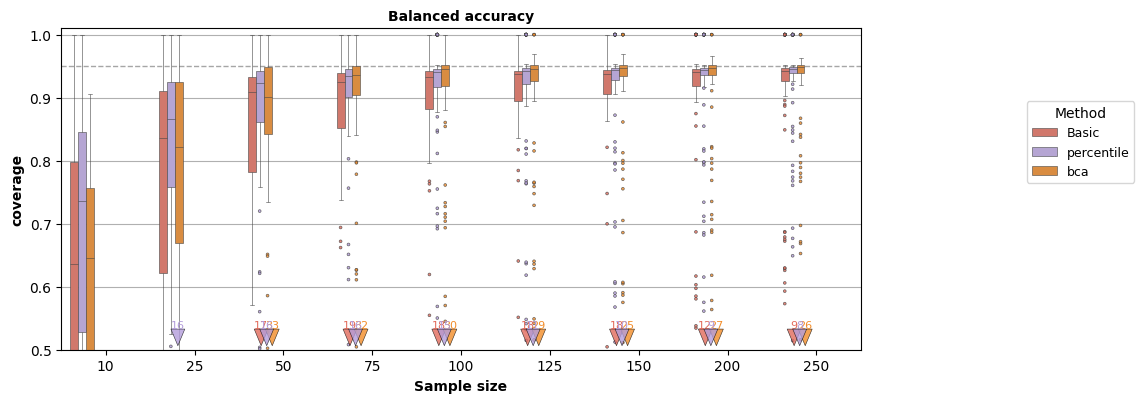

In [21]:
method_colors = {
    'Basic': '#e26b5b',
    'percentile': '#b39ddb',
    'bca': '#f28c28',
    'agresti_coull': "#5f8761",
    'wald': "#74b2e3",
    'wilson': "#ecd476", 
    'exact': "#e3a7e5",
    'delong':'#ffb3ba',
    'logit_transform':'#bae1ff',
}
hue_order = ['Basic', 'percentile', 'bca', 'agresti_coull', 'wald', 'wilson','exact', 'delong', 'logit_transform']
        


n_rows = 1
n_cols = 1


# Define stat order

all_stats = df_ba['stat'].unique()


fig, axes = plt.subplots(n_rows, n_cols, figsize=(12 * n_cols, 4.5 * n_rows), squeeze=False)

ax = axes[0][0]
ax.axhline(0.95, linestyle='--', color='gray', linewidth=1, alpha=0.7)
# Filter data for this stat and metric

df_sub=df_ba.sort_values(by='n')
# Plot boxplot

sns.boxplot(
    data=df_sub,
    x='x_group',
    y='value',
    hue='method',
    hue_order=hue_order,
    palette=method_colors,
    showfliers=False,
    width=0.8,
    ax=ax, 
    linewidth=0.4
)

# Compute whiskers and outliers
whiskers = {}
groups = df_sub.groupby(['x_group', 'method'])
lower_whiskers = []
for (x_group, method), group_data in groups:
    Q1 = group_data['value'].quantile(0.25)
    Q3 = group_data['value'].quantile(0.75)
    IQR = Q3 - Q1
    lw = Q1 - 1.5 * IQR
    uw = Q3 + 1.5 * IQR
    whiskers[(x_group, method)] = (lw, uw)
    lower_whiskers.append(lw)

y_lower_limit = min(lower_whiskers) if lower_whiskers else 0

outliers = []
for (x_group, method), (lw, uw) in whiskers.items():
    subset = df_sub[(df_sub['x_group'] == x_group) & (df_sub['method'] == method)]
    outliers.append(subset[(subset['value'] < lw) | (subset['value'] > uw)])

outliers_df = pd.concat(outliers) if outliers else pd.DataFrame(columns=df_sub.columns)

if not outliers_df.empty:
    sns.stripplot(
        data=outliers_df,
        x='x_group',
        y='value',
        hue='method',
        hue_order=hue_order,
        palette=method_colors,
        dodge=True,
        jitter=0.0,
        alpha=0.8,
        size=2,
        legend=False,
        edgecolor="auto",
        linewidth=0.5,
        ax=ax
    )

# Clean x-axis labels
xtick_labels = [label.get_text().replace('n=', '').replace('.0', '').split('\n')[-1] for label in ax.get_xticklabels()]
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(xtick_labels, rotation=0)
ax.set_ylim(0.5, 1.01)
# Axis titles and labels

ax.set_title('Balanced accuracy', fontsize=10, weight='bold')

ax.set_ylabel(f"coverage",fontsize=10,weight='bold')

ax.set_xlabel('Sample size', weight='bold',fontsize=10)
# ax.set_ylim(0.5- 0.01, 1.01)
ax.grid(axis='y')
# ax.set_ylim(y_lower_limit - 0.01, 1.01)
dodge_width = 0.5  # total spread
methods = hue_order
method_offsets = {
    method: -dodge_width / 2 + i * (dodge_width / (len(methods)-1 if len(methods) > 1 else 1))
    for i, method in enumerate(methods)
}
# --- Annotate clipped outliers ---
for (x_group, method), (lw, uw) in whiskers.items():
    
    subset = df_sub[(df_sub['x_group'] == x_group) & (df_sub['method'] == method)]
    coverages = subset['value']
    

    # Skip if IQR is not fully within the plot (box is truncated)
    if lw < 0.5- 0.01:
        continue 
    count_below = (coverages < ax.get_ylim()[0]).sum()
    count_above = (coverages > ax.get_ylim()[1]).sum()
    x_pos = list(df_sub['x_group'].unique()).index(x_group)
    offset = method_offsets[method]
    pos = x_pos + offset
    if count_below > 0:
        ax.annotate(f'{count_below}',
                    xy=(pos, ax.get_ylim()[0] + 0.005),
                    xytext=(pos, ax.get_ylim()[0] + 0.035),
                    ha='center',
                    arrowprops=dict(
                        facecolor=method_colors[method],
                        shrink=0.05,
                        width=6,
                        headwidth=10, alpha=0.8, linewidth=0.4
                    ),
                    bbox=dict(boxstyle='square,pad=0.1', fc="white", ec="none", alpha=0),
                    fontsize=8,
                    color=method_colors[method])
        # ax.annotate(f'{count_below}',
        #                                 xy=(pos, 0.505),
        #                                 xytext=(pos, 0.525),
        #                                 ha='center',
        #                                 arrowprops=dict(facecolor=colors[method], shrink=0.05, width=8, headwidth=16),
        #                                 bbox = dict(boxstyle='square,pad=0.1', fc="white", ec="none"),
        #                                 fontsize=60, color=colors[method])
    if count_above > 0:
        ax.annotate(f'{count_above}',
                    xy=(pos, ax.get_ylim()[1] - 0.005),
                    xytext=(pos, ax.get_ylim()[1] - 0.005),
                    ha='center',
                    va='bottom',
                    fontsize=10,
                    fontweight="bold",
                    bbox=dict(
                        boxstyle='circle,pad=0.1',
                        fc="none",
                        ec=method_colors[method],
                        lw=2
                    ),
                    color=method_colors[method])
        # Remove duplicate legends
handles, labels = ax.get_legend_handles_labels()

    # Determine which methods are present in the subplot's data
methods_in_data = df_sub['method'].unique()

# Filter the legend entries
filtered_handles_labels = [
    (h, l) for h, l in zip(handles, labels) if l in methods_in_data
]

# Apply filtered legend
if filtered_handles_labels:
    handles_filt, labels_filt = zip(*filtered_handles_labels)
    ax.legend(handles_filt, labels_filt, title="Method", loc="lower right",  bbox_to_anchor=(1.35, 0.5), fontsize=9, title_fontsize=10)
else:
    if ax.legend_ is not None:
        ax.legend_.remove()

# Global legend
# fig.legend(handles, labels, title='Method', loc='lower center', ncol=len(hue_order), frameon=False,fontsize=20,          # Increase legend label font size
#     title_fontsize=25)

# Adjust layout
plt.subplots_adjust(bottom=0.15, wspace=0.2, hspace=0.4)

plt.tight_layout(rect=[0, 0.08, 1, 1])  # Leave space for legend
fig.savefig("classification_all.pdf", format="pdf", bbox_inches="tight")
plt.show()


### Width

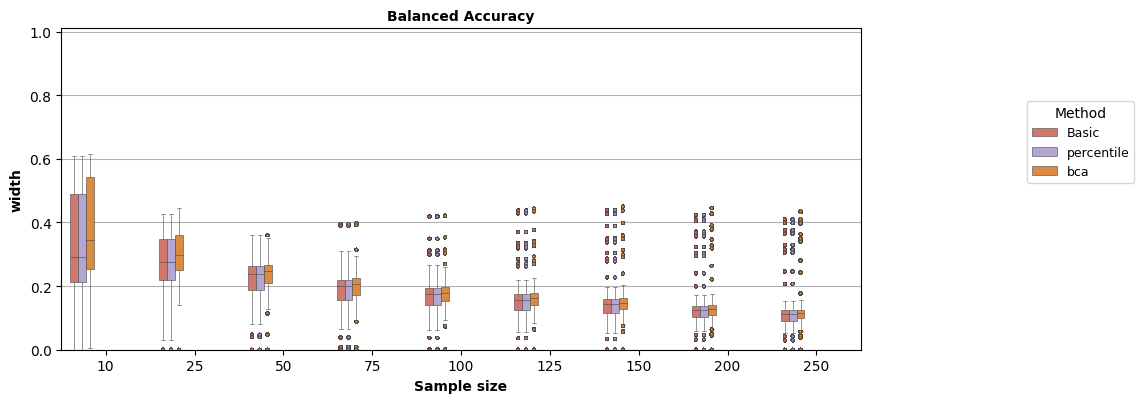

In [22]:

method_colors = {
    'Basic': '#e26b5b',
    'percentile': '#b39ddb',
    'bca': '#f28c28',
    'agresti_coull': "#5f8761",
    'wald': "#74b2e3",
    'wilson': "#ecd476", 
    'exact': "#e3a7e5",
    'delong':'#ffb3ba',
    'logit_transform':'#bae1ff',
}
hue_order = ['Basic', 'percentile', 'bca', 'agresti_coull', 'wald', 'wilson','exact', 'delong', 'logit_transform']
        


n_rows = 1
n_cols = 1


# Define stat order


fig, axes = plt.subplots(n_rows, n_cols, figsize=(12 * n_cols, 4.5 * n_rows), squeeze=False)

ax = axes[0][0]

# Filter data for this stat and metric

df_ba=df_width[df_width['stat']=='balanced_accuracy']
df_sub=df_ba.sort_values(by='n')
# Plot boxplot

sns.boxplot(
    data=df_sub,
    x='x_group',
    y='width',
    hue='method',
    hue_order=hue_order,
    palette=method_colors,
    showfliers=False,
    width=0.8,
    ax=ax, 
    linewidth=0.4
)

# Compute whiskers and outliers
whiskers = {}
groups = df_sub.groupby(['x_group', 'method'])
lower_whiskers = []
for (x_group, method), group_data in groups:
    Q1 = group_data['width'].quantile(0.25)
    Q3 = group_data['width'].quantile(0.75)
    IQR = Q3 - Q1
    lw = Q1 - 1.5 * IQR
    uw = Q3 + 1.5 * IQR
    whiskers[(x_group, method)] = (lw, uw)
    lower_whiskers.append(lw)

y_lower_limit = min(lower_whiskers) if lower_whiskers else 0

outliers = []
for (x_group, method), (lw, uw) in whiskers.items():
    subset = df_sub[(df_sub['x_group'] == x_group) & (df_sub['method'] == method)]
    outliers.append(subset[(subset['width'] < lw) | (subset['width'] > uw)])

outliers_df = pd.concat(outliers) if outliers else pd.DataFrame(columns=df_sub.columns)

if not outliers_df.empty:
    sns.stripplot(
        data=outliers_df,
        x='x_group',
        y='width',
        hue='method',
        hue_order=hue_order,
        palette=method_colors,
        dodge=True,
        jitter=0.0,
        alpha=0.8,
        size=2,
        legend=False,
        edgecolor="auto",
        linewidth=0.5,
        ax=ax
    )

# Clean x-axis labels
xtick_labels = [label.get_text().replace('n=', '').replace('.0', '').split('\n')[-1] for label in ax.get_xticklabels()]
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(xtick_labels, rotation=0)

# Axis titles and labels

ax.set_title('Balanced Accuracy', fontsize=10, weight='bold')

ax.set_ylabel(f"width",fontsize=10,weight='bold')
ax.set_ylim(0,1.01)
ax.set_xlabel('Sample size', weight='bold',fontsize=10)
# ax.set_ylim(0.5- 0.01, 1.01)
ax.grid(axis='y')
# ax.set_ylim(y_lower_limit - 0.01, 1.01)
dodge_width = 0.5  # total spread
methods = hue_order
method_offsets = {
    method: -dodge_width / 2 + i * (dodge_width / (len(methods)-1 if len(methods) > 1 else 1))
    for i, method in enumerate(methods)
}
# --- Annotate clipped outliers ---
for (x_group, method), (lw, uw) in whiskers.items():
    
    subset = df_sub[(df_sub['x_group'] == x_group) & (df_sub['method'] == method)]
    coverages = subset['width']
    

    # Skip if IQR is not fully within the plot (box is truncated)
    if lw < 0.5- 0.01:
        continue 
    count_below = (coverages < ax.get_ylim()[0]).sum()
    count_above = (coverages > ax.get_ylim()[1]).sum()
    x_pos = list(df_sub['x_group'].unique()).index(x_group)
    offset = method_offsets[method]
    pos = x_pos + offset
    if count_below > 0:
        ax.annotate(f'{count_below}',
                    xy=(pos, ax.get_ylim()[0] + 0.005),
                    xytext=(pos, ax.get_ylim()[0] + 0.035),
                    ha='center',
                    arrowprops=dict(
                        facecolor=method_colors[method],
                        shrink=0.05,
                        width=6,
                        headwidth=10, alpha=0.8, linewidth=0.4
                    ),
                    bbox=dict(boxstyle='square,pad=0.1', fc="white", ec="none", alpha=0),
                    fontsize=8,
                    color=method_colors[method])
        # ax.annotate(f'{count_below}',
        #                                 xy=(pos, 0.505),
        #                                 xytext=(pos, 0.525),
        #                                 ha='center',
        #                                 arrowprops=dict(facecolor=colors[method], shrink=0.05, width=8, headwidth=16),
        #                                 bbox = dict(boxstyle='square,pad=0.1', fc="white", ec="none"),
        #                                 fontsize=60, color=colors[method])
    if count_above > 0:
        ax.annotate(f'{count_above}',
                    xy=(pos, ax.get_ylim()[1] - 0.005),
                    xytext=(pos, ax.get_ylim()[1] - 0.005),
                    ha='center',
                    va='bottom',
                    fontsize=10,
                    fontweight="bold",
                    bbox=dict(
                        boxstyle='circle,pad=0.1',
                        fc="none",
                        ec=method_colors[method],
                        lw=2
                    ),
                    color=method_colors[method])
        # Remove duplicate legends
handles, labels = ax.get_legend_handles_labels()

    # Determine which methods are present in the subplot's data
methods_in_data = df_sub['method'].unique()

# Filter the legend entries
filtered_handles_labels = [
    (h, l) for h, l in zip(handles, labels) if l in methods_in_data
]

# Apply filtered legend
if filtered_handles_labels:
    handles_filt, labels_filt = zip(*filtered_handles_labels)
    ax.legend(handles_filt, labels_filt, title="Method", loc="lower right",  bbox_to_anchor=(1.35, 0.5), fontsize=9, title_fontsize=10)
else:
    ax.legend_.remove()

# Global legend
# fig.legend(handles, labels, title='Method', loc='lower center', ncol=len(hue_order), frameon=False,fontsize=20,          # Increase legend label font size
#     title_fontsize=25)

# Adjust layout
plt.subplots_adjust(bottom=0.15, wspace=0.2, hspace=0.4)

plt.tight_layout(rect=[0, 0.08, 1, 1])  # Leave space for legend
fig.savefig("classification_width_macro.pdf", format="pdf", bbox_inches="tight")
plt.show()


## Fail cases AP

In [23]:
fail_cases=[]
df_ap=df_coverage[df_coverage['stat']=='ap']
for n in df_ap['n'].unique():
    print(n)
    data_n=df_ap[df_ap['n']==n]
    for method in ['basic', 'bca', 'percentile']:
        print(method)
        data_method=data_n[data_n['method']==method]
        coverage=np.sort(data_method['value'])
        for cov in coverage[:7]:
            data_coverage=data_method[data_method['value']==cov ]
            print(data_coverage['subtask'].to_numpy(), data_coverage['algo'].to_numpy())
            fail_cases.append({'n':n, 
                               'method':method,
                               'coverage':cov,
                               'subtask':data_coverage['subtask'].to_numpy()[0],
                               'algo': data_coverage['algo'].to_numpy()[0]}
                               )
            
fail_cases_df=pd.DataFrame(fail_cases)



10.0
basic
bca
['isic20_melanoma_classification'] ['alg_6']
['isic20_melanoma_classification'] ['alg_18']
['isic20_melanoma_classification'] ['alg_13']
['isic20_melanoma_classification'] ['alg_19']
['isic20_melanoma_classification'] ['alg_14']
['isic20_melanoma_classification'] ['alg_2']
['isic20_melanoma_classification'] ['alg_17']
percentile
['isic20_melanoma_classification'] ['alg_6']
['isic20_melanoma_classification'] ['alg_18']
['isic20_melanoma_classification'] ['alg_13']
['isic20_melanoma_classification'] ['alg_19']
['isic20_melanoma_classification'] ['alg_14']
['isic20_melanoma_classification'] ['alg_2']
['isic20_melanoma_classification'] ['alg_17']
25.0
basic
bca
['isic20_melanoma_classification'] ['alg_19']
['isic20_melanoma_classification'] ['alg_13']
['isic20_melanoma_classification'] ['alg_14']
['isic20_melanoma_classification'] ['alg_18']
['isic20_melanoma_classification'] ['alg_17']
['isic20_melanoma_classification'] ['alg_2']
['isic20_melanoma_classification'] ['alg_11'

In [24]:
for n in fail_cases_df['n'].unique():

    data_n=fail_cases_df[fail_cases_df['n']==n]
    for method in data_n['method'].unique():
        data_method=data_n[data_n['method']==method]
        
    print('samples:', n, 'tasks:', data_n['subtask'].unique(),data_n['algo'].unique() )

samples: 10.0 tasks: ['isic20_melanoma_classification'] ['alg_6' 'alg_18' 'alg_13' 'alg_19' 'alg_14' 'alg_2' 'alg_17']
samples: 25.0 tasks: ['isic20_melanoma_classification'] ['alg_19' 'alg_13' 'alg_14' 'alg_18' 'alg_17' 'alg_2' 'alg_11']
samples: 50.0 tasks: ['isic20_melanoma_classification'] ['alg_18' 'alg_14' 'alg_2' 'alg_13' 'alg_17' 'alg_11' 'alg_19']
samples: 75.0 tasks: ['isic20_melanoma_classification'] ['alg_14' 'alg_18' 'alg_13' 'alg_17' 'alg_2' 'alg_19' 'alg_11']
samples: 100.0 tasks: ['isic20_melanoma_classification'] ['alg_18' 'alg_14' 'alg_13' 'alg_17' 'alg_19' 'alg_2' 'alg_11']
samples: 125.0 tasks: ['isic20_melanoma_classification'] ['alg_18' 'alg_14' 'alg_13' 'alg_17' 'alg_19' 'alg_2' 'alg_11']
samples: 150.0 tasks: ['isic20_melanoma_classification'] ['alg_14' 'alg_18' 'alg_13' 'alg_17' 'alg_2' 'alg_19' 'alg_11']
samples: 250.0 tasks: ['isic20_melanoma_classification'] ['alg_14' 'alg_17' 'alg_18' 'alg_13' 'alg_2' 'alg_11' 'alg_19']
samples: 200.0 tasks: ['isic20_melano

In [25]:
data_dist=pd.read_csv('../../données/classif/data_matrix_classification.csv')

In [26]:
data_dist=data_dist[data_dist['subtask']=='isic20_melanoma_classification']

In [27]:
data_dist

,subtask,alg_name,sample_id,logits,target
8478,isic20_melanoma_classification,alg_1,0,"{-6.133, 7.18}",0
8479,isic20_melanoma_classification,alg_1,1,"{1.769, -1.406}",0
8480,isic20_melanoma_classification,alg_1,2,"{3.963, -3.4}",0
8481,isic20_melanoma_classification,alg_1,3,"{3.936, -3.105}",0
8482,isic20_melanoma_classification,alg_1,4,"{-5.297, 4.773}",0
...,...,...,...,...,...
757568,isic20_melanoma_classification,alg_19,6536,"{1.51, -1.907}",1
757569,isic20_melanoma_classification,alg_19,6537,"{1.529, -2.068}",1
757570,isic20_melanoma_classification,alg_19,6538,"{1.501, -2.047}",1
757571,isic20_melanoma_classification,alg_19,6539,"{1.4, -2.008}",1


In [28]:

def parse_vector_string(vec_str):
    # Remove curly braces and split by comma
    vec_str = vec_str.strip('{}')
    parts = vec_str.split(',')
    # Convert each part to float (strip whitespace just in case)
    return [float(x.strip()) for x in parts]

In [29]:
for algos in ['alg_19' 'alg_13' 'alg_14' 'alg_18' 'alg_17' 'alg_2' 'alg_11']:
    if algos in data_dist['alg_name'].unique():
        df_algo=data_dist[data_dist['alg_name']==algos]
        print(algos)
        logits = df_algo['logits']
        list_of_lists = logits.apply(parse_vector_string).tolist()
        max_len = max(len(vec) for vec in list_of_lists)
        list_of_lists = [vec for vec in list_of_lists if len(vec) == max_len]
        matrix_logits = np.array(list_of_lists)
    
        targets =df_algo['target']

        
        num_classes = matrix_logits.shape[1]

        # Count samples per true class
        class_counts = pd.Series(targets).value_counts().sort_index()
        class_labels = [f"class_{i} (n={class_counts.get(i, 0)})" for i in range(num_classes)]

        # Make labeled DataFrame
        df_logits = pd.DataFrame(matrix_logits, columns=class_labels)
        df_long_logits = df_logits.melt(var_name="class", value_name="probability")
        df_long_logits["class"] = pd.Categorical(df_long_logits["class"], categories=class_labels)
        df = pd.DataFrame(matrix_logits, columns=class_labels)
        df_long = df.melt(var_name="class", value_name="logits")
        df_long["class"] = pd.Categorical(df_long["class"], categories=class_labels)

        # Accuracy from metrics fil
        # Plot
        fig, ax = plt.subplots(1, 1, figsize=(14, 5), sharey=False)
        sns.histplot(
            data=df_long,
            x="logits",
            hue="class",
            stat="density",
            bins=50,
            common_norm=False,
            palette="tab10",
            element="step",
            linewidth=1.5,
            legend="full",
            ax=ax
        )
        ax.set_title(f"Logits Distribution algo {algos} on task 'isic20_melanoma_classification'")
        ax.set_xlabel("Predicted Logits")
        ax.set_ylabel("Density")
        
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

## Plot to show fail basic

In [30]:
metrics=['iou', 'boundary_iou','assd', 'cldice', 'hd', 'dsc', 'nsd', 'masd', 'hd_perc' ]
stats=['mean', 'median', 'std', 'trimmed_mean', 'iqr_length']
all_values=[]
means=[]
for metric in metrics:
    for stat in stats:
        file_path = f"../../données/segmentation/results_metrics_segm/aggregated_results_{metric}_{stat}.csv"
        data = pd.read_csv(file_path)
        n_subset=data['n'].unique()
        tasks=data['subtask'].unique()
        algos=data['alg_name'].unique()
        for task in tasks: 
            data_task=data[data['subtask']==task]
            for algo in algos: 
                data_algo=data_task[data_task['alg_name']==algo]
        medians=[]
        for n in n_subset: 
            print(n) # Show only selected n values
            data_n = data[data['n'] == n]
            method_dict = {
                'Basic': 'contains_true_stat_basic',
                'bca': 'contains_true_stat_bca',
                'percentile': 'contains_true_stat_percentile',
            }

            # Add parametric methods only for stat == 'mean'
            if stat == 'mean':
                method_dict.update({
                    'Parametric z': 'contains_true_stat_param_z',
                    'Parametric t': 'contains_true_stat_param_t'
                })
            for method, col in method_dict.items():
                medians.append({'method':method, 
                                "median": np.median(data_n[col]), 
                                'n':n})
                for val in data_n[col]:

                    all_values.append({
                        'metric': metric,
                        'stat': stat,
                        'n': n,
                        'method': method,
                        'value': val,
                        'x_group': f"{metric}\nn={n}"
                    })
        median_df=pd.DataFrame(medians)
        

10.0
25.0
50.0
75.0
100.0
125.0
150.0
200.0
250.0
10.0
25.0
50.0
75.0
100.0
125.0
150.0
200.0
250.0
10.0
25.0
50.0
75.0
100.0
125.0
150.0
200.0
250.0
10.0
25.0
50.0
75.0
100.0
125.0
150.0
200.0
250.0
10.0
25.0
50.0
75.0
100.0
125.0
150.0
200.0
250.0
10.0
25.0
50.0
75.0
100.0
125.0
150.0
200.0
250.0
10.0
25.0
50.0
75.0
100.0
125.0
150.0
200.0
250.0
10.0
25.0
50.0
75.0
100.0
125.0
150.0
200.0
250.0
10.0
25.0
50.0
75.0
100.0
125.0
150.0
200.0
250.0
10.0
25.0
50.0
75.0
100.0
125.0
150.0
200.0
250.0
10.0
25.0
50.0
75.0
100.0
125.0
150.0
200.0
250.0
10.0
25.0
50.0
75.0
100.0
125.0
150.0
200.0
250.0
10.0
25.0
50.0
75.0
100.0
125.0
150.0
200.0
250.0
10.0
25.0
50.0
75.0
100.0
125.0
150.0
200.0
250.0
10.0
25.0
50.0
75.0
100.0
125.0
150.0
200.0
250.0
10.0
25.0
50.0
75.0
100.0
125.0
150.0
200.0
250.0
10.0
25.0
50.0
75.0
100.0
125.0
150.0
200.0
250.0
10.0
25.0
50.0
75.0
100.0
125.0
150.0
200.0
250.0
10.0
25.0
50.0
75.0
100.0
125.0
150.0
200.0
250.0
10.0
25.0
50.0
75.0
100.0
125.0
150.0
200.0
250.0


In [31]:
df=pd.DataFrame(all_values)
df

,metric,stat,n,method,value,x_group
0,iou,mean,10.0,Basic,0.8906,iou\nn=10.0
1,iou,mean,10.0,Basic,0.8819,iou\nn=10.0
2,iou,mean,10.0,Basic,0.8785,iou\nn=10.0
3,iou,mean,10.0,Basic,0.8859,iou\nn=10.0
4,iou,mean,10.0,Basic,0.8868,iou\nn=10.0
...,...,...,...,...,...,...
276619,hd_perc,iqr_length,250.0,percentile,0.9393,hd_perc\nn=250.0
276620,hd_perc,iqr_length,250.0,percentile,0.9704,hd_perc\nn=250.0
276621,hd_perc,iqr_length,250.0,percentile,0.9626,hd_perc\nn=250.0
276622,hd_perc,iqr_length,250.0,percentile,0.9597,hd_perc\nn=250.0


In [32]:
all_metrics = df['metric'].unique()
bounded_metrics=['iou', 'boundary_iou', 'dsc','nsd','cldice']
unbounded_metrics = [m for m in all_metrics if m not in bounded_metrics]

means_bounded=[]
means_unbounded=[]
for n in df['n'].unique():
    data_n=df[df['n']==n]
    for method in data_n['method'].unique():
        print(method)
        data_method=data_n[data_n['method']==method]
        medians_bounded=[]
        medians_unbounded=[]
        for metric in bounded_metrics:
            data_metric=data_method[data_method['metric']==metric]
            for stat in data_metric['stat'].unique():
                data_stat=data_metric[data_metric['stat']==stat]
                medians_bounded.append(np.median(data_stat['value']))
        for metric in unbounded_metrics:
            data_metric=data_method[data_method['metric']==metric]
            for stat in data_metric['stat'].unique():
                data_stat=data_metric[data_metric['stat']==stat]
                medians_unbounded.append(np.median(data_stat['value']))
        means_bounded.append({'n':n,
                       'method':method, 
                       'median':np.mean(medians_bounded)})
        means_unbounded.append({'n':n,
                       'method':method, 
                       'median':np.mean(medians_unbounded)})

Basic
bca
percentile
Parametric z
Parametric t
Basic
bca
percentile
Parametric z
Parametric t
Basic
bca
percentile
Parametric z
Parametric t
Basic
bca
percentile
Parametric z
Parametric t
Basic
bca
percentile
Parametric z
Parametric t
Basic
bca
percentile
Parametric z
Parametric t
Basic
bca
percentile
Parametric z
Parametric t
Basic
bca
percentile
Parametric z
Parametric t
Basic
bca
percentile
Parametric z
Parametric t


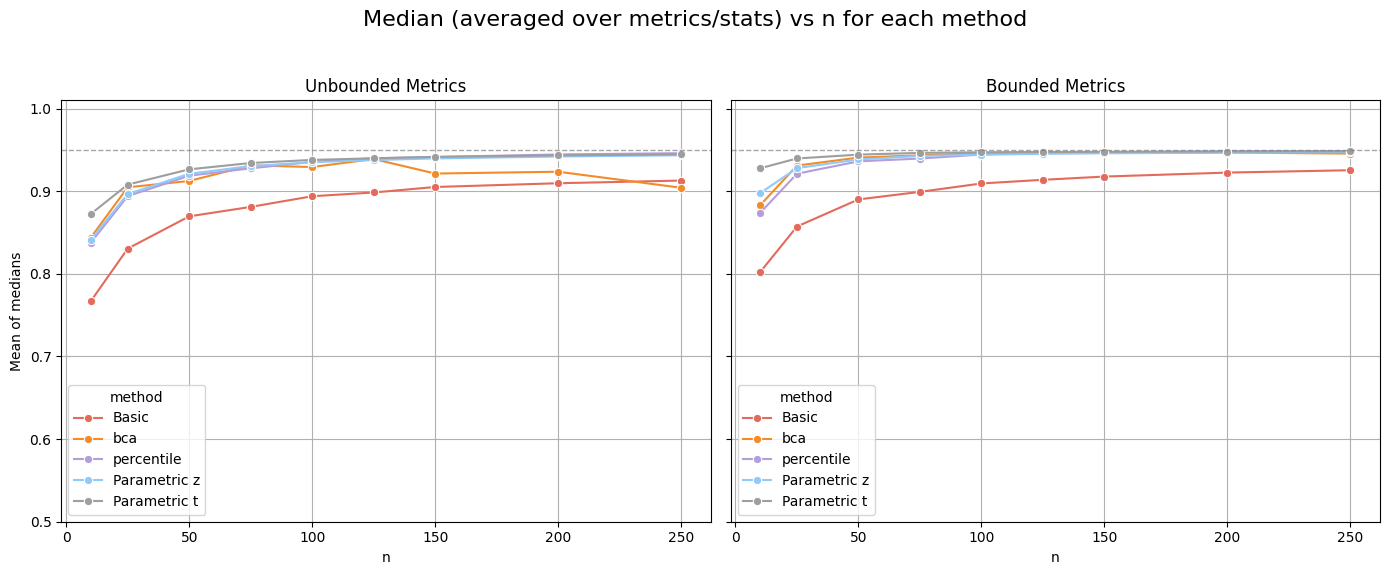

In [33]:
means_unbounded_df=pd.DataFrame(means_unbounded)
means_bounded_df = pd.DataFrame(means_bounded)
method_colors = {
    'Basic': '#e26b5b',
    'percentile': '#b39ddb',
    'bca': '#f28c28',
    'Parametric t': '#9e9e9e',
    'Parametric z': '#90caf9'
}
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Unbounded plot
sns.lineplot(
    data=means_unbounded_df,
    x='n', y='median', hue='method',
    marker='o', palette=method_colors, ax=ax[0]
)
ax[0].axhline(0.95, linestyle='--', color='gray', linewidth=1, alpha=0.7)
ax[0].set_title('Unbounded Metrics')
ax[0].set_xlabel('n')
ax[0].set_ylabel('Mean of medians')
ax[0].grid(True)

# Bounded plot
sns.lineplot(
    data=means_bounded_df,
    x='n', y='median', hue='method',
    marker='o', palette=method_colors, ax=ax[1]
)
ax[1].set_title('Bounded Metrics')
ax[1].set_xlabel('n')
ax[1].grid(True)
ax[1].axhline(0.95, linestyle='--', color='gray', linewidth=1, alpha=0.7)

# Adjust layout and limits
plt.suptitle('Median (averaged over metrics/stats) vs n for each method', fontsize=16)
plt.ylim(0.5, 1.01)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave room for suptitle
plt.show()


## Impact of distributions

In [34]:
all_metrics = df['metric'].unique()
bounded_metrics=['iou', 'boundary_iou', 'dsc','nsd','cldice']
unbounded_metrics = [m for m in all_metrics if m not in bounded_metrics]

medians=[]

for n in df['n'].unique():
    data_n=df[df['n']==n]
    for method in data_n['method'].unique():

        data_method=data_n[data_n['method']==method]
    
        for metric in data_method['metric'].unique():
            data_metric=data_method[data_method['metric']==metric]
            for stat in data_metric['stat'].unique():
                data_stat=data_metric[data_metric['stat']==stat]
            
                medians.append({'method':method, 
                                'n':n, 
                                'median':np.median(data_stat['value']),
                                'metric':metric,
                                'stat':stat})
        

In [35]:
median_df=pd.DataFrame(medians)

In [36]:
median_df

,method,n,median,metric,stat
0,Basic,10.0,0.87985,iou,mean
1,Basic,10.0,0.78285,iou,median
2,Basic,10.0,0.79110,iou,std
3,Basic,10.0,0.84710,iou,trimmed_mean
4,Basic,10.0,0.76125,iou,iqr_length
...,...,...,...,...,...
1372,Parametric t,250.0,0.94700,hd,mean
1373,Parametric t,250.0,0.94840,dsc,mean
1374,Parametric t,250.0,0.94740,nsd,mean
1375,Parametric t,250.0,0.94320,masd,mean


/var/folders/4w/1glyl09x27jfg8kpgbdzrwv40000gp/T/ipykernel_58316/1625661280.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/var/folders/4w/1glyl09x27jfg8kpgbdzrwv40000gp/T/ipykernel_58316/1625661280.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


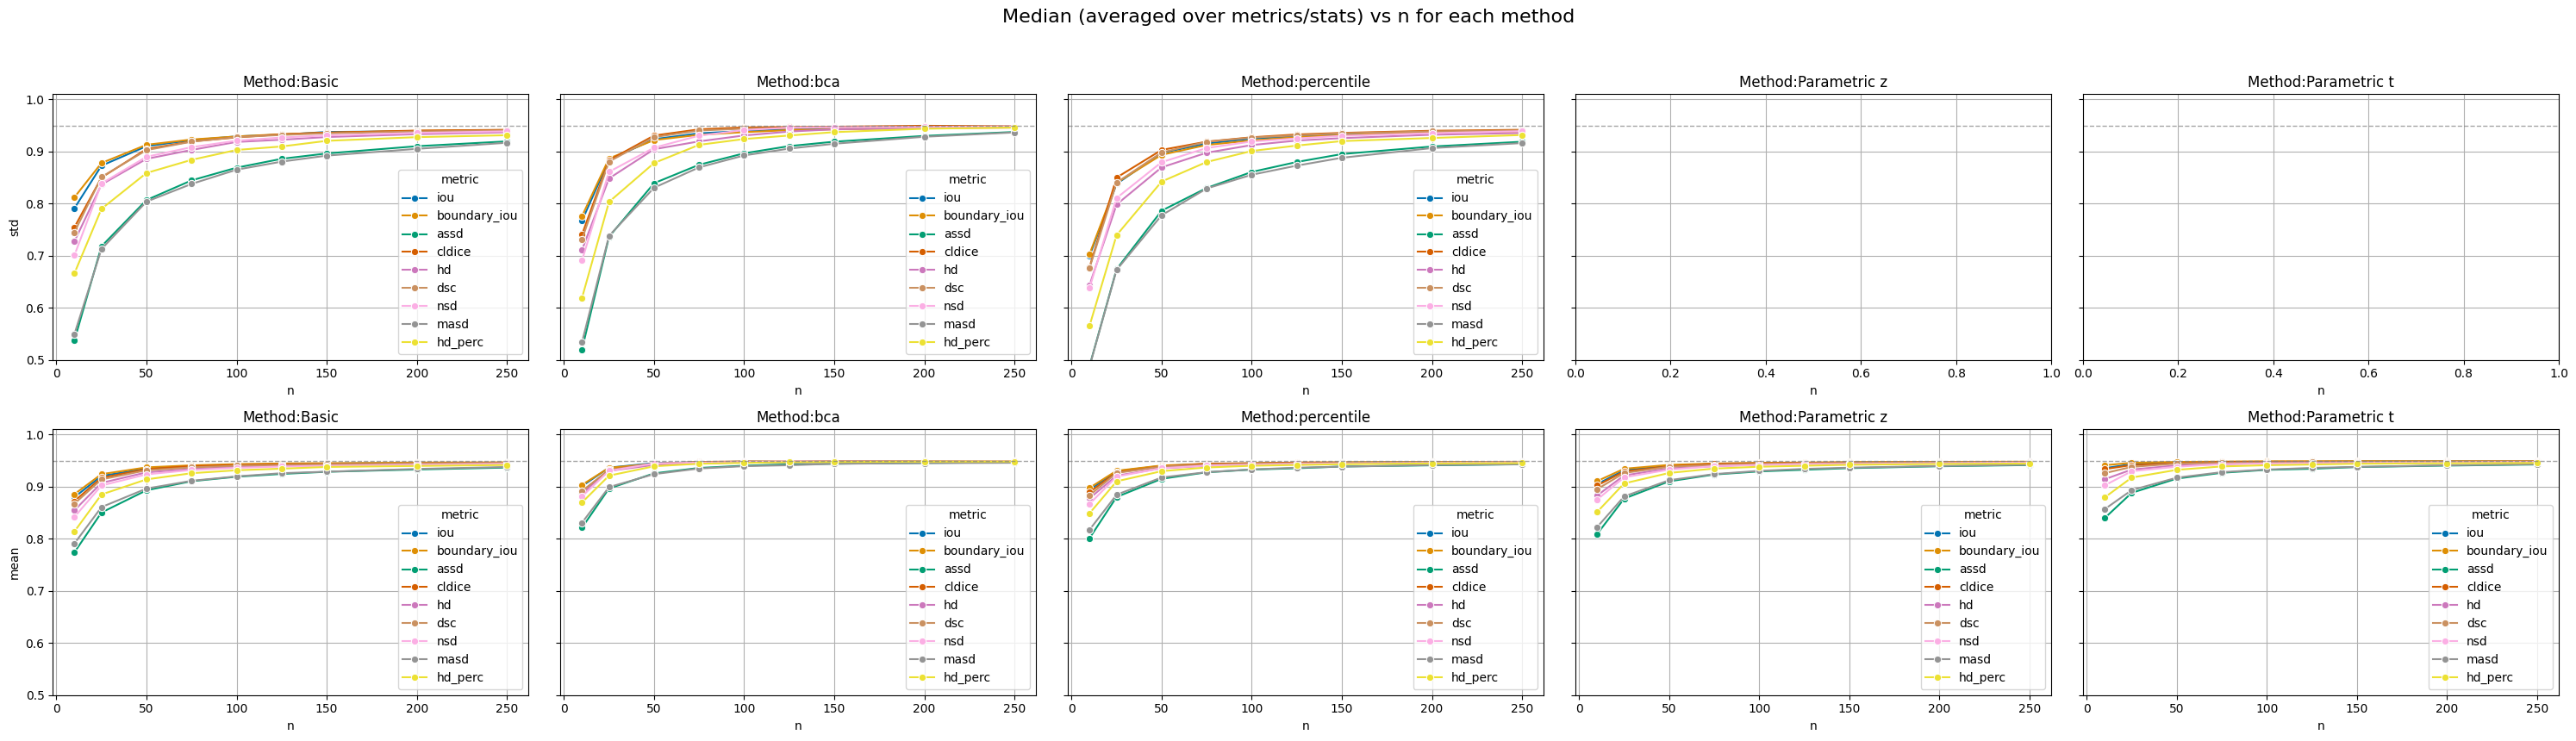

In [37]:

palette = sns.color_palette("colorblind", len(metrics))
color_dict = dict(zip(metrics, palette))
stats=median_df['stat'].unique()
methods=median_df['method'].unique()
n_rows=2
n_cols=len(methods)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows), sharey=True)
for i,method in enumerate(methods):
    data_method=median_df[median_df['method']==method]
    for j,stat in enumerate(['std', 'mean']):
        data_stat=data_method[data_method['stat']==stat]
        ax=axes[j][i]
        sns.lineplot(
            data=data_stat,
            x='n', y='median', hue='metric',
            marker='o', ax=ax, palette=color_dict
        )
        ax.axhline(0.95, linestyle='--', color='gray', linewidth=1, alpha=0.7)
        ax.set_title(f'Method:{method}')
        ax.set_xlabel('n')
        ax.set_ylabel( f'{stat}')
        ax.grid(True)


# Adjust layout and limits
plt.suptitle('Median (averaged over metrics/stats) vs n for each method', fontsize=16)
plt.ylim(0.5, 1.01)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave room for suptitle
plt.show()


0.06604999999999994
0.04744999999999999
0.05325000000000002
0.04259999999999997
0.013349999999999973
0.06104999999999994
0.045050000000000034
0.04999999999999993
0.037250000000000005
0.007849999999999913
0.16269999999999996
0.12549999999999994
0.14189999999999992
0.13249999999999995
0.10289999999999999
0.07385000000000008
0.05764999999999998
0.057599999999999985
0.045050000000000034
0.014549999999999952
0.08960000000000001
0.06119999999999992
0.0686
0.06299999999999994
0.03290000000000004
0.07824999999999993
0.05730000000000002
0.06410000000000005
0.05205000000000004
0.02244999999999997
0.10209999999999997
0.06730000000000003
0.07974999999999999
0.07114999999999994
0.044950000000000045
0.14679999999999993
0.11509999999999998
0.12570000000000003
0.11970000000000003
0.08640000000000003
0.12770000000000004
0.0786
0.09640000000000004
0.09309999999999996
0.06630000000000003
0.11585000000000001
0.021299999999999986
0.01815
0.11509999999999998
0.020750000000000046
0.017699999999999938
0.08149

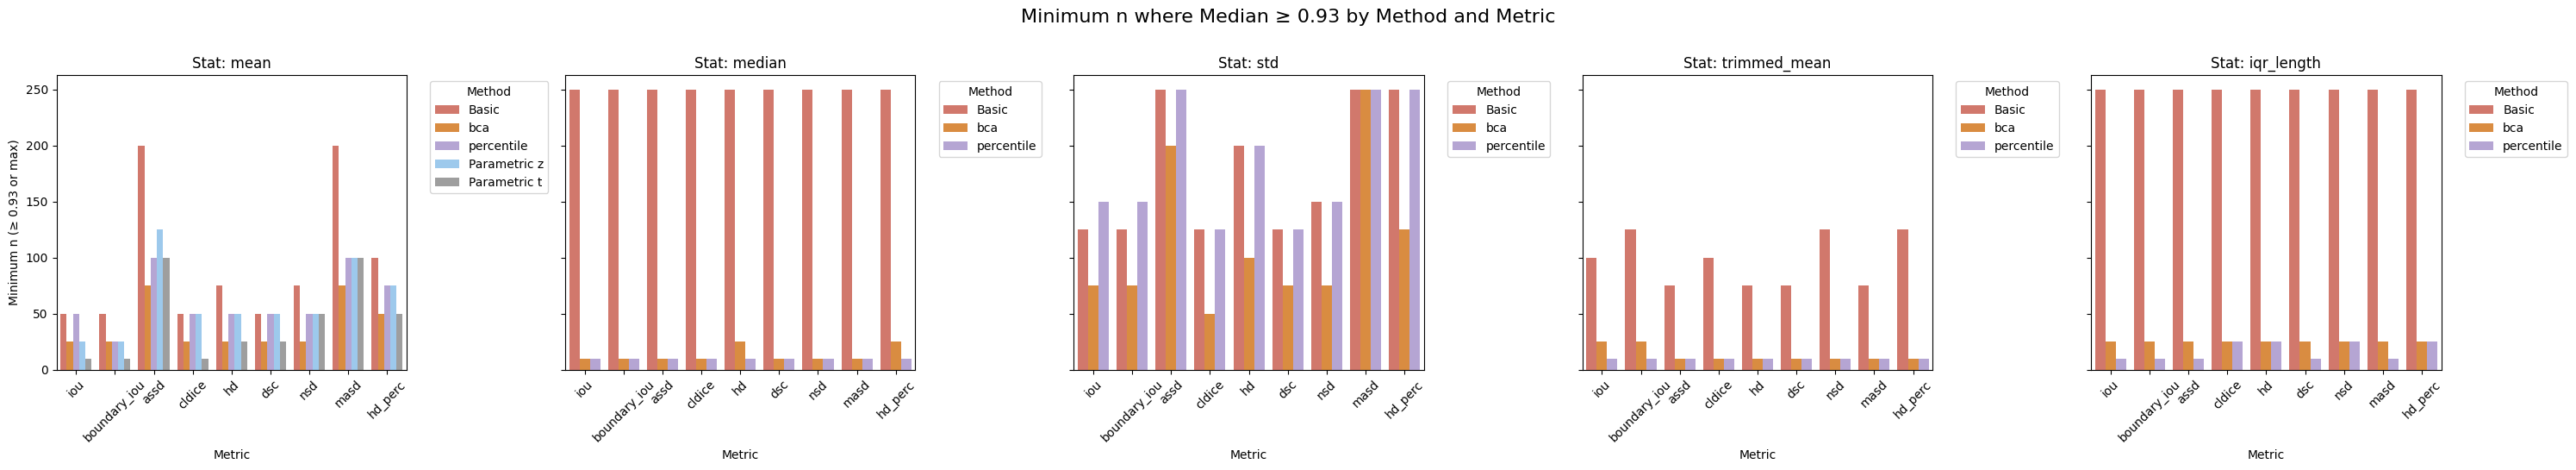

In [38]:

method_colors = {
    'Basic': '#e26b5b',
    'percentile': '#b39ddb',
    'bca': '#f28c28',
    'Parametric t': '#9e9e9e',
    'Parametric z': '#90caf9'
}

# Build min_n list with fallback to max(n) if threshold not reached
threshold = 0.93
min_n_list = []

for stat in median_df['stat'].unique():
    df_stat = median_df[median_df['stat'] == stat]
    for metric in df_stat['metric'].unique():
        for method in df_stat['method'].unique():
            df_sub = df_stat[(df_stat['metric'] == metric) & (df_stat['method'] == method)]
            df_above = df_sub[df_sub['median'] >= threshold]
            difference=df_sub['median'].max()-df_sub['median'].min()
            print(difference)
            if not df_above.empty:
                min_n = df_above['n'].min()
                is_fallback = False
                max_median = None

            else:
                min_n = df_sub['n'].max()  # fallback
                is_fallback = True
                max_median = df_sub['median'].max()
            min_n_list.append({
                'stat': stat,
                'metric': metric,
                'method': method,
                'min_n': min_n,
                'difference':difference,
                'is_fallback': is_fallback,
                'max_median': max_median
            })

# Convert to DataFrame
min_n_df = pd.DataFrame(min_n_list)

# Plotting
stats = min_n_df['stat'].unique()
n_stats = len(stats)

fig, axes = plt.subplots(1, n_stats, figsize=(6 * n_stats, 5), sharey=True)

# Ensure axes is iterable
if n_stats == 1:
    axes = [axes]

for i, stat in enumerate(stats):
    ax = axes[i]
    data = min_n_df[min_n_df['stat'] == stat]

    sns.barplot(
        data=data,
        x='metric',
        y='min_n',
        hue='method',
        palette=method_colors,
        ax=ax
    )
    ax.set_title(f'Stat: {stat}')
    ax.set_ylabel('Minimum n (≥ 0.93 or max)')
    ax.set_xlabel('Metric')
   
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.suptitle('Minimum n where Median ≥ 0.93 by Method and Metric', fontsize=16, y=1.08)
plt.show()


## Bca fail for order stats

In [39]:
all_metrics = df['metric'].unique()
bounded_metrics=['iou', 'boundary_iou', 'dsc','nsd','cldice']
unbounded_metrics = [m for m in all_metrics if m not in bounded_metrics]

fixed_stats = ['mean', 'std', 'trimmed_mean']
all_stats = df['stat'].unique()
remaining_stats = [s for s in all_stats if s not in fixed_stats]
stat_order = fixed_stats + sorted(remaining_stats)
means_bounded=[]
means_unbounded=[]
means_bounded_order=[]
means_unbounded_order=[]
for n in df['n'].unique():
    data_n=df[df['n']==n]

    for method in ['Basic', 'bca']:
        print(method)
        data_method=data_n[data_n['method']==method]
 
        medians_bounded_order=[]
        medians_unbounded_order=[]
        medians_bounded=[]
        medians_unbounded=[]
        for metric in bounded_metrics:
            print('bounded', metric)
            data_metric=data_method[data_method['metric']==metric]
         
            for stat in remaining_stats:
                data_stat=data_metric[data_metric['stat']==stat]
                medians_bounded_order.append(np.median(data_stat['value']))
            for stat in fixed_stats:
                data_stat=data_metric[data_metric['stat']==stat]
                medians_bounded.append(np.median(data_stat['value']))
        for metric in unbounded_metrics:
            print('unbounded',metric)
            data_metric=data_method[data_method['metric']==metric]
            for stat in remaining_stats:
                data_stat=data_metric[data_metric['stat']==stat]
                medians_unbounded_order.append(np.median(data_stat['value']))
            for stat in fixed_stats:
                data_stat=data_metric[data_metric['stat']==stat]
                medians_unbounded.append(np.median(data_stat['value']))
        means_bounded.append({'n':n,
                       'method':method, 
                       'median':np.mean(medians_bounded)})
        means_unbounded.append({'n':n,
                       'method':method, 
                       'median':np.mean(medians_unbounded)})
        means_bounded_order.append({'n':n,
                       'method':method, 
                       'median':np.mean(medians_bounded_order)})
        means_unbounded_order.append({'n':n,
                       'method':method, 
                       'median':np.mean(medians_unbounded_order)})
        

Basic
bounded iou
bounded boundary_iou
bounded dsc
bounded nsd
bounded cldice
unbounded assd
unbounded hd
unbounded masd
unbounded hd_perc
bca
bounded iou
bounded boundary_iou
bounded dsc
bounded nsd
bounded cldice
unbounded assd
unbounded hd
unbounded masd
unbounded hd_perc
Basic
bounded iou
bounded boundary_iou
bounded dsc
bounded nsd
bounded cldice
unbounded assd
unbounded hd
unbounded masd
unbounded hd_perc
bca
bounded iou
bounded boundary_iou
bounded dsc
bounded nsd
bounded cldice
unbounded assd
unbounded hd
unbounded masd
unbounded hd_perc
Basic
bounded iou
bounded boundary_iou
bounded dsc
bounded nsd
bounded cldice
unbounded assd
unbounded hd
unbounded masd
unbounded hd_perc
bca
bounded iou
bounded boundary_iou
bounded dsc
bounded nsd
bounded cldice
unbounded assd
unbounded hd
unbounded masd
unbounded hd_perc
Basic
bounded iou
bounded boundary_iou
bounded dsc
bounded nsd
bounded cldice
unbounded assd
unbounded hd
unbounded masd
unbounded hd_perc
bca
bounded iou
bounded boundary_

0     Basic
1       bca
2     Basic
3       bca
4     Basic
5       bca
6     Basic
7       bca
8     Basic
9       bca
10    Basic
11      bca
12    Basic
13      bca
14    Basic
15      bca
16    Basic
17      bca
Name: method, dtype: object
Empty DataFrame
Columns: [n, method, median]
Index: []


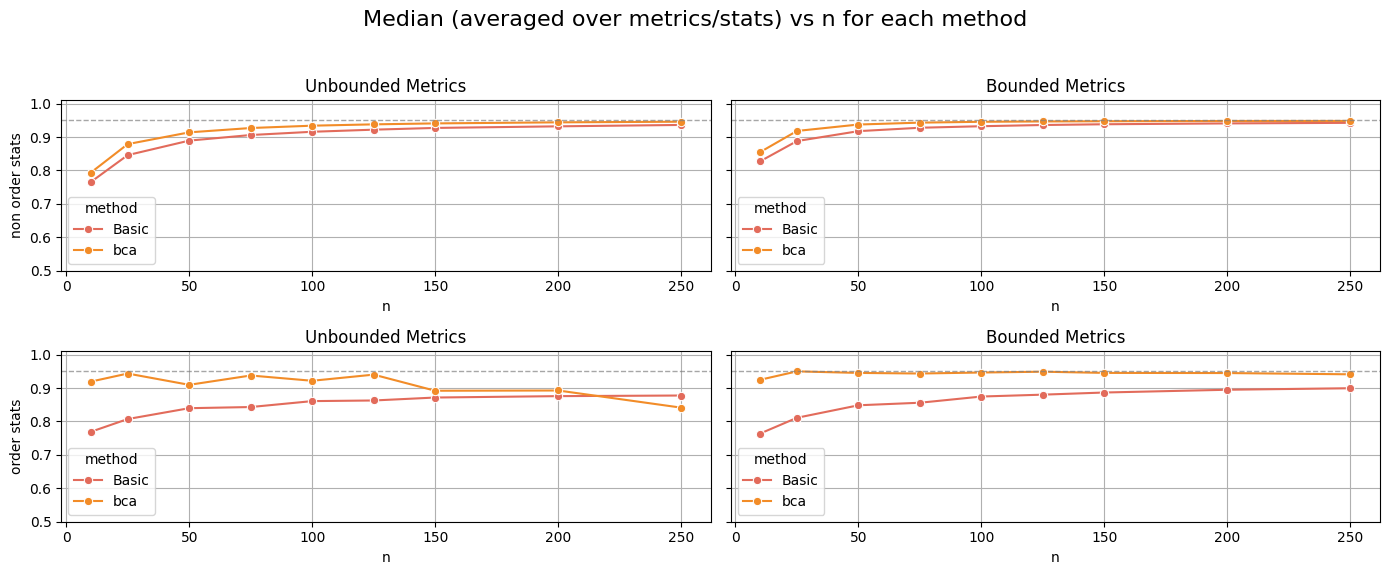

In [40]:
means_unbounded_df=pd.DataFrame(means_unbounded)
means_bounded_df = pd.DataFrame(means_bounded)
means_unbounded_order_df=pd.DataFrame(means_unbounded_order)
means_bounded_order_df = pd.DataFrame(means_bounded_order)
print(means_bounded_order_df['method'])
method_colors = {
    'Basic': '#e26b5b',
    'percentile': '#b39ddb',
    'bca': '#f28c28',
    'Parametric t': '#9e9e9e',
    'Parametric z': '#90caf9'
}
fig, ax = plt.subplots(2, 2, figsize=(14, 6), sharey=True)
print(means_unbounded_order_df[means_unbounded_order_df['method']=='basic'])
# Unbounded plot
sns.lineplot(
    data=means_unbounded_df,
    x='n', y='median', hue='method',
    marker='o', palette=method_colors, ax=ax[0][0]
)
ax[0][0].axhline(0.95, linestyle='--', color='gray', linewidth=1, alpha=0.7)
ax[0][0].set_title('Unbounded Metrics')
ax[0][0].set_xlabel('n')
ax[0][0].set_ylabel('non order stats')
ax[0][0].grid(True)

# Bounded plot
sns.lineplot(
    data=means_unbounded_order_df,
    x='n', y='median', hue='method',
    marker='o', palette=method_colors, ax=ax[1][0]
)
ax[1][0].set_title('Unbounded Metrics')
ax[1][0].set_xlabel('n')
ax[1][0].grid(True)
ax[1][0].set_ylabel('order stats')
ax[1][0].axhline(0.95, linestyle='--', color='gray', linewidth=1, alpha=0.7)
# Unbounded plot
sns.lineplot(
    data=means_bounded_df,
    x='n', y='median', hue='method',
    marker='o', palette=method_colors, ax=ax[0][1]
)
ax[0][1].axhline(0.95, linestyle='--', color='gray', linewidth=1, alpha=0.7)
ax[0][1].set_title('Bounded Metrics')
ax[0][1].set_xlabel('n')
ax[0][1].set_ylabel('non order stats')
ax[0][1].grid(True)

# Bounded plot
sns.lineplot(
    data=means_bounded_order_df,
    x='n', y='median', hue='method',
    marker='o', palette=method_colors, ax=ax[1][1]
)
ax[1][1].set_title('Bounded Metrics')
ax[1][1].set_xlabel('n')
ax[1][1].grid(True)
ax[1][1].set_ylabel('order stats')
ax[1][1].axhline(0.95, linestyle='--', color='gray', linewidth=1, alpha=0.7)

# Adjust layout and limits
plt.suptitle('Median (averaged over metrics/stats) vs n for each method', fontsize=16)
plt.ylim(0.5, 1.01)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave room for suptitle
plt.show()